In [127]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14}) #make plots more readable

import palettable as pal

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

##############################
### User defined functions ###
##############################

#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

# def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
#     ra1 = np.copy(ra)
#     dec1 = np.copy(dec)
#     ra1 = np.radians(ra1)
#     dec1 = np.radians(dec1)
#     alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
#     delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
#     sd = np.sin(delt0)
#     cd = np.cos(delt0)
#     d0 = 49.9
#     io = io*np.pi/180 #np.radians(io) #inclination #25.86
#     pa = (pa+90)*np.pi/180 #np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
#     cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
#     sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
#     sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
#     dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
#     return dis

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [3]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/abparam16_delgau1.5_1525.txt')

In [4]:
############################################
### Create a list of all possible models ###
############################################

import itertools as it

y1 = parsec['logTe']
y2 = parsec['Ksmag']
y3 = np.log10(parsec['Zini']/0.02)
y4  = parsec['logg']
y12 = np.multiply(y1,y2)
y13 = np.multiply(y1,y3)
y14 = np.multiply(y1,y4)
y23 = np.multiply(y2,y3)
y24 = np.multiply(y2,y4)
y34 = np.multiply(y3,y4)
y1sq = y1**2
y2sq = y2**2
y3sq = y3**2
y4sq = y4**2

models = []
models_str = []
all_var_str = ['y1','y2','y3','y4','y12','y13','y14','y23','y24','y34','y1sq','y2sq','y3sq','y4sq']
all_var = [y1,y2,y3,y4,y12,y13,y14,y23,y24,y34,y1sq,y2sq,y3sq,y4sq]
for i in range(4, len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
    
idx = []
for j in range(len(models_str)):
    if models_str[j][0]=='y1' and models_str[j][1]=='y2' and models_str[j][2]=='y3' and models_str[j][3]=='y4':
        idx.append(j)
        
models = np.array(models)[idx]
models_str_good = np.array(models_str)[idx]

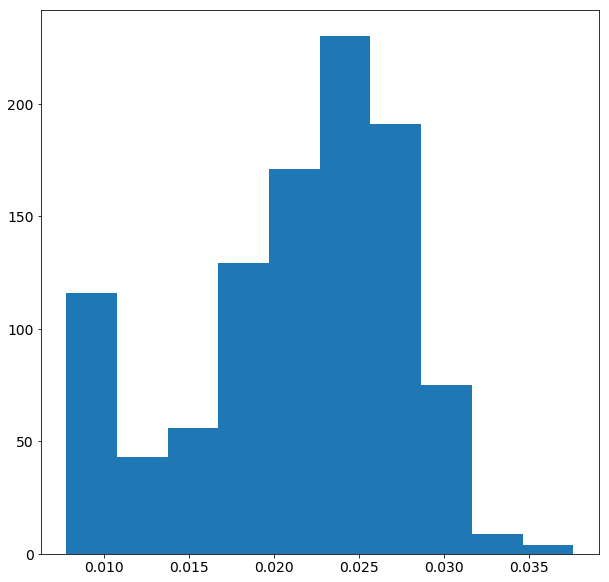

0.007780979977408009
[array(['y1', 'y2', 'y3', 'y4', 'y12', 'y13', 'y23', 'y24', 'y34', 'y2sq',
       'y3sq', 'y4sq'], dtype='<U4')]
[array([ 2.07483027e+01,  1.25330396e+00,  4.38762008e+00,  3.15757396e+00,
       -6.92771748e+00, -3.98506724e-01, -8.32023943e-01, -8.80250421e-03,
       -5.27532676e-01,  5.78640717e-02,  1.16480914e-01,  4.97348135e-02,
        6.19034227e-01])]


In [5]:
######################
### Fit All Models ###
######################

import statsmodels.api as sm 

model_mads = []
model_params = []
model_res = []
for i in range(len(models)):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logAge'],pmodl).fit()
    predictions = model.predict(pmodl)
    residual = predictions - parsec['logAge']
    model_res.append(max(np.absolute(residual)))
    model_mads.append(mad(residual))
    model_params.append(np.asarray(model.params))
    
plt.figure(figsize=[10,10])
plt.hist(model_mads)
plt.show()
    
best = np.where(model_mads == min(model_mads))
print(min(model_mads))
print(models_str_good[best])
print(np.asarray(model_params)[best])

In [6]:
#########################
### Find lowest order ###
#########################

small = np.where(np.asarray(model_mads)<=0.01)

terms = []
for i in range(len(models_str_good[small])):
    terms.append(len(models_str_good[small][i]))
    
print(terms)
for j in range(6):
    print(models_str_good[small][j])

[9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14]
['y1' 'y2' 'y3' 'y4' 'y12' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y14' 'y24' 'y34' 'y2sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y14' 'y24' 'y1sq' 'y2sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y14' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y23' 'y24' 'y2sq' 'y3sq' 'y4sq']
['y1' 'y2' 'y3' 'y4' 'y24' 'y34' 'y2sq' 'y3sq' 'y4sq']


In [7]:
parsimonious = np.array([y1,y2,y3,y4,y24,y34,y2sq,y4sq]).T
parsimonious = sm.add_constant(parsimonious)
parsimonious_model = sm.OLS(parsec['logAge'],parsimonious).fit()
parsimonious_predictions = parsimonious_model.predict(parsimonious)
parsimonious_residual = parsimonious_predictions - parsec['logAge']
parsimonious_summary = parsimonious_model.summary()
print(parsimonious_summary)
print(np.asarray(parsimonious_model.params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.880e+06
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:00:44   Log-Likelihood:                 41961.
No. Observations:               16121   AIC:                        -8.390e+04
Df Residuals:                   16112   BIC:                        -8.384e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.9003      0.072    400.224      0.0

In [8]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [33]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [11]:
# plt.hist(factsCO[iuvenis],color='k')
# plt.hist(factsCO[senex],color='r')
# print(np.median(factsCO[iuvenis]))
# print(mad(factsCO[iuvenis]))
# print(np.median(factsCO[senex]))
# print(mad(factsCO[senex]))

In [12]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [13]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

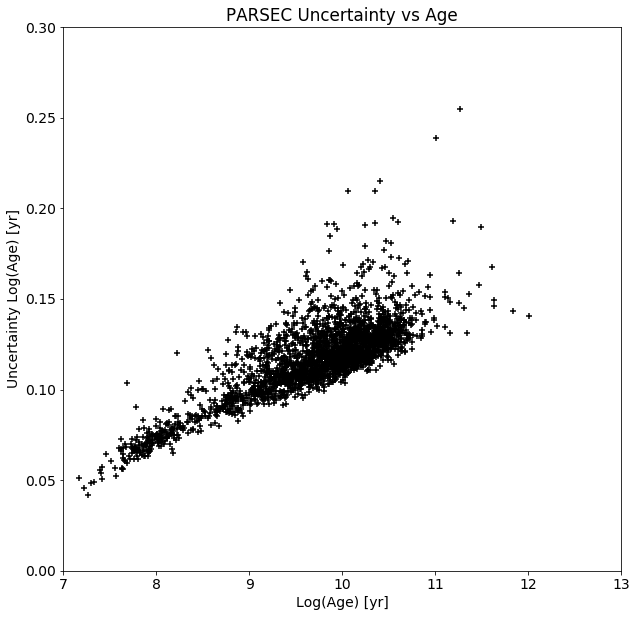

In [34]:
########################
### Uncertainty Plot ###
########################

plt.figure(figsize=[10,10])
plt.scatter(parage,devs,c='k',marker='+',label='Polynomial')
#plt.scatter(clnpdfout['P_MEAN'],clnpdfout['P_VAR'],c='r',marker='+',label='Bayesian')
plt.xlim(7,13)
#plt.axvline(10.13+np.mean(devs),c='k')
plt.xlabel(r'Log(Age) [yr]')
plt.ylabel(r'Uncertainty Log(Age) [yr]')
plt.ylim(0.0,0.3)
plt.title(r'PARSEC Uncertainty vs Age')
#plt.legend()
plt.savefig('parsec_uncert_age.pdf',bbox_inches='tight')
plt.show()

In [15]:
x = np.array([1, 0, 2, 3, 4])
y = np.array([2, 1, 4, 3, 6])
xy, x_ind, y_ind = np.intersect1d(x, y, return_indices=True)
# x_ind, y_ind

# print(x[np.squeeze(np.argwhere(np.in1d(x, y)))])
# print(y[np.squeeze(np.argwhere(np.in1d(y, x)))])

# print(x[np.in1d(x,y)])
# print(y[np.in1d(y,x)])

In [16]:
#############################
### Match old DR16 to R13 ###
#############################

'''Diane used the old file'''

xy, x_ind, y_ind = np.intersect1d(clnrolddr16['APOGEE_ID'], clndr16['APOGEE_ID'],return_indices=True)

1

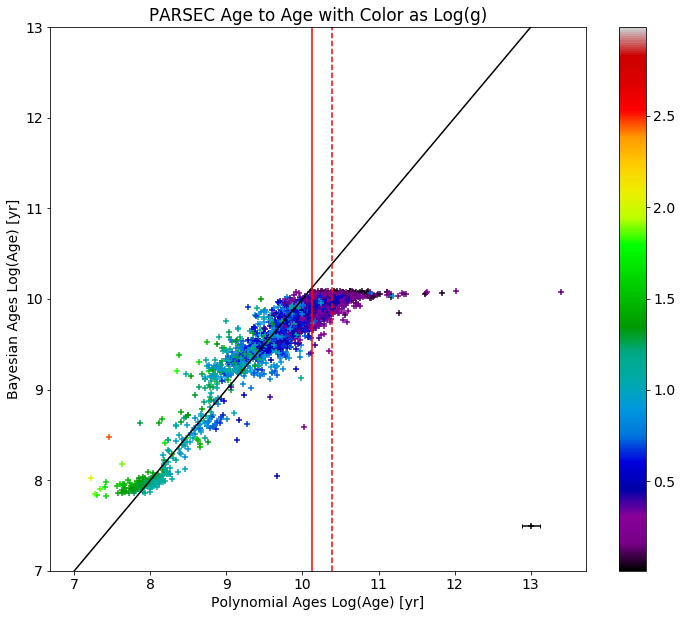

In [35]:
########################
### compare to Diane ###
########################

plt.figure(figsize=[12,10])
plt.scatter(parage[y_ind],clnpdfout['P_MEAN'][x_ind],c=clndr16['LOGG'][y_ind],marker='+',cmap='nipy_spectral')
plt.colorbar()
plt.plot([7,8,9,10,11,12,13],[7,8,9,10,11,12,13],c='k')
plt.ylim(7,13)
plt.scatter(13,7.5,c='k',marker='+')
plt.errorbar(13,7.5,xerr=np.mean(devs),c='k',capsize=2)
plt.axvline(10.13,c='r')
plt.axvline(10.13+np.max(devs),c='r',linestyle='--')
plt.xlabel(r'Polynomial Ages Log(Age) [yr]')
plt.ylabel(r'Bayesian Ages Log(Age) [yr]')
plt.title(r'PARSEC Age to Age with Color as Log(g)')
plt.savefig('parsec_age_age.pdf',bbox_inches='tight')
plt.show()

In [36]:
np.asarray(devs)[x_ind]
len(np.where(parage[x_ind]>(10.13+np.max(np.asarray(devs)[x_ind]))))/len(parage[x_ind])*100

0.044111160123511246

In [37]:
len(np.where(parage>(10.13+np.max(devs))))/len(parage)*100

0.04120313143798929

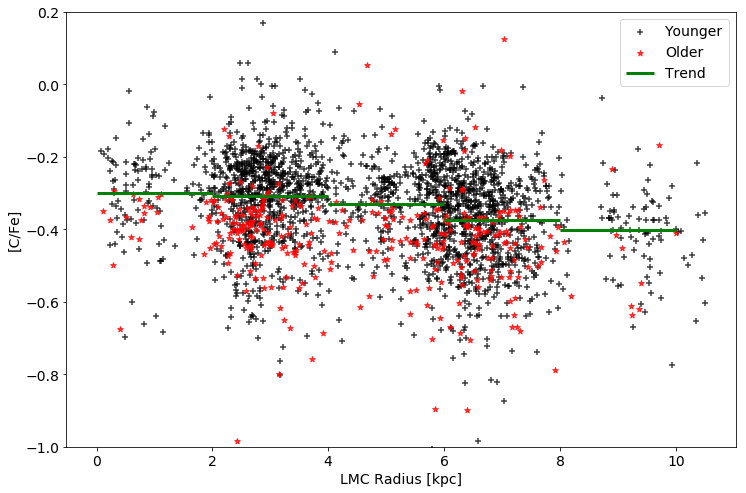

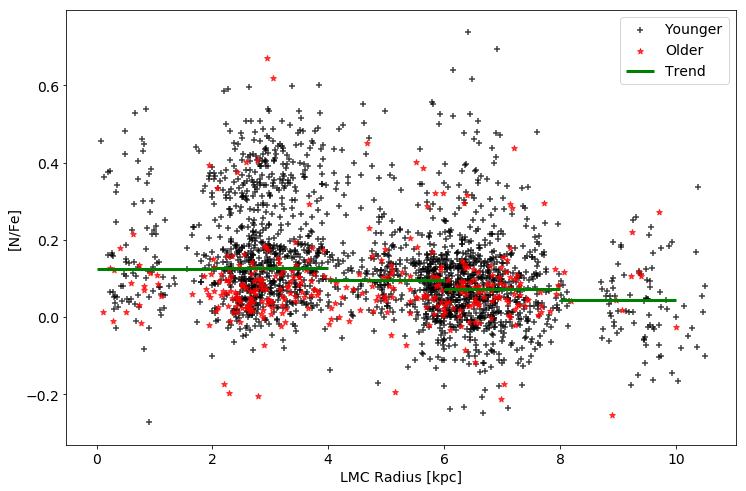

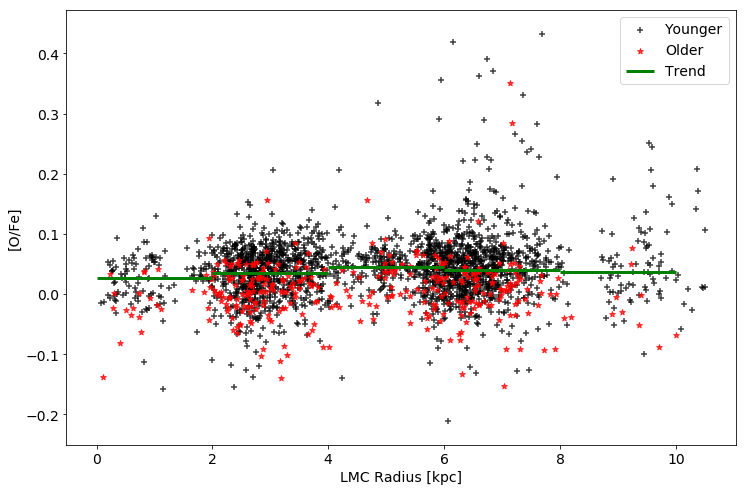

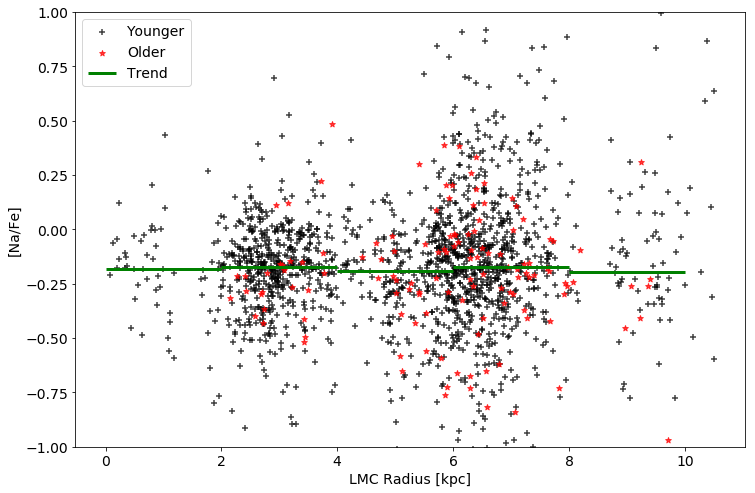

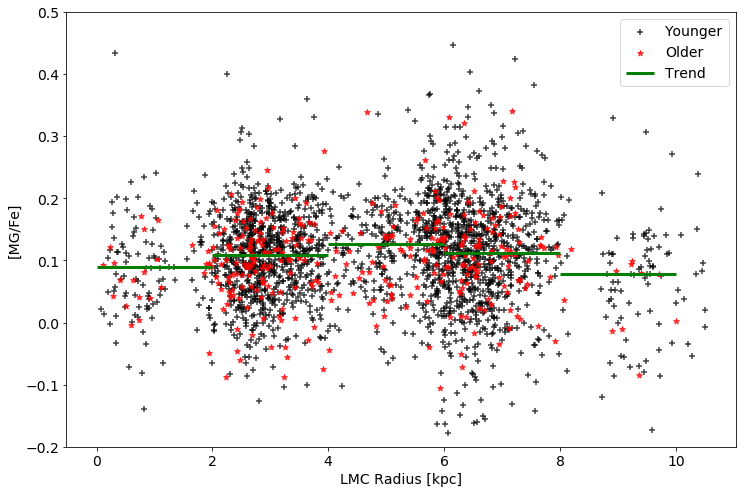

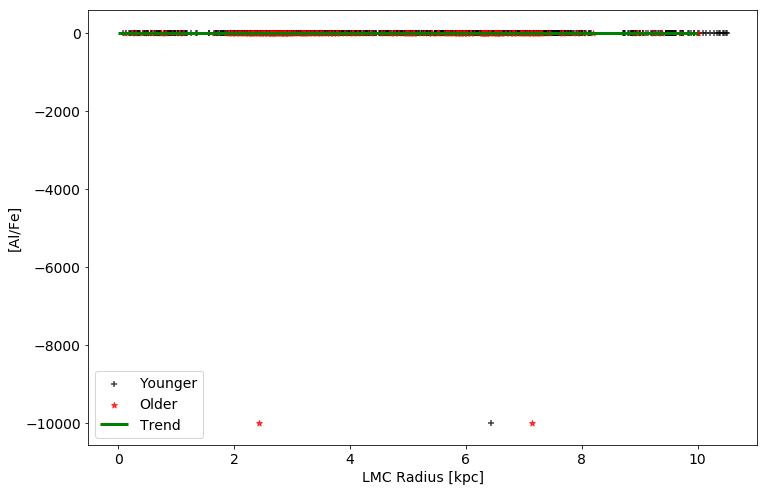

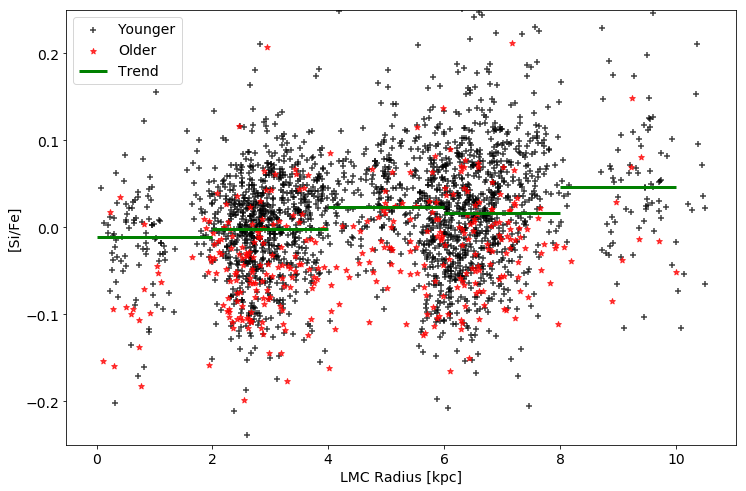

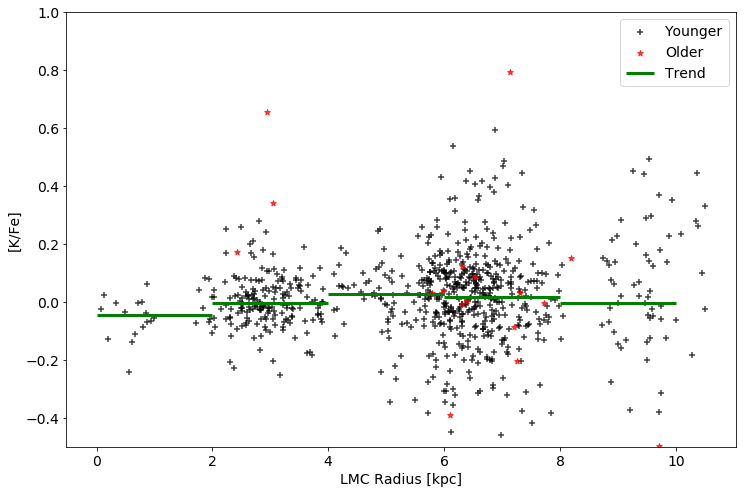

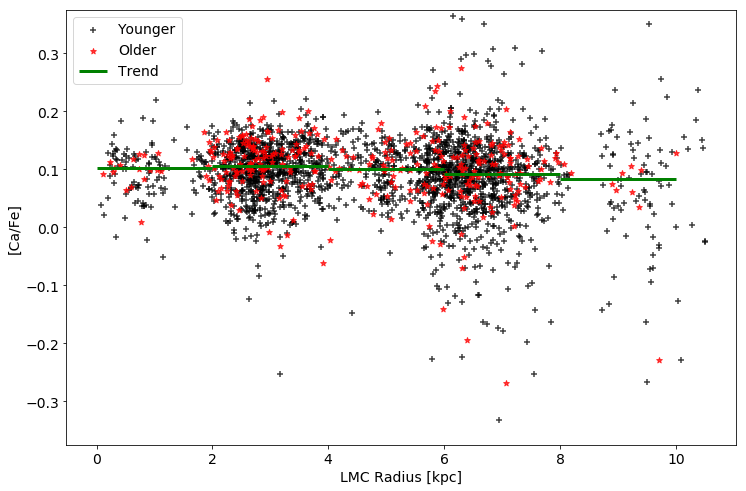

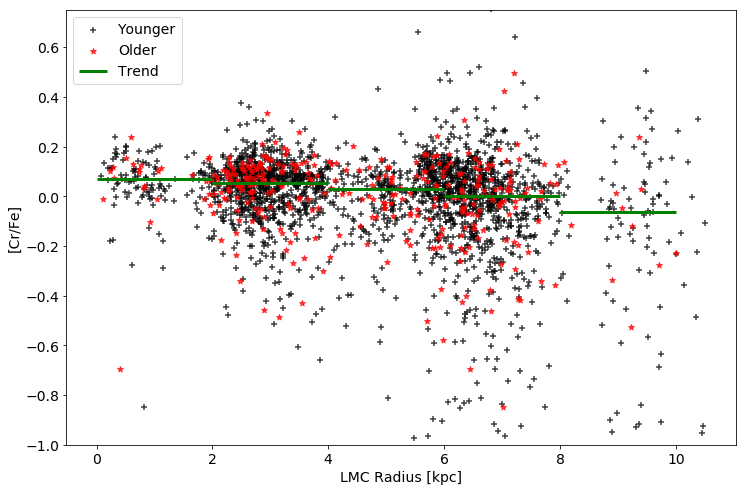

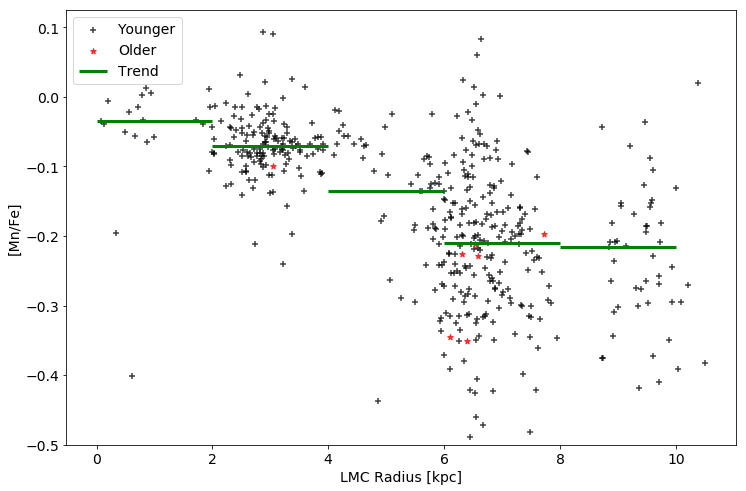

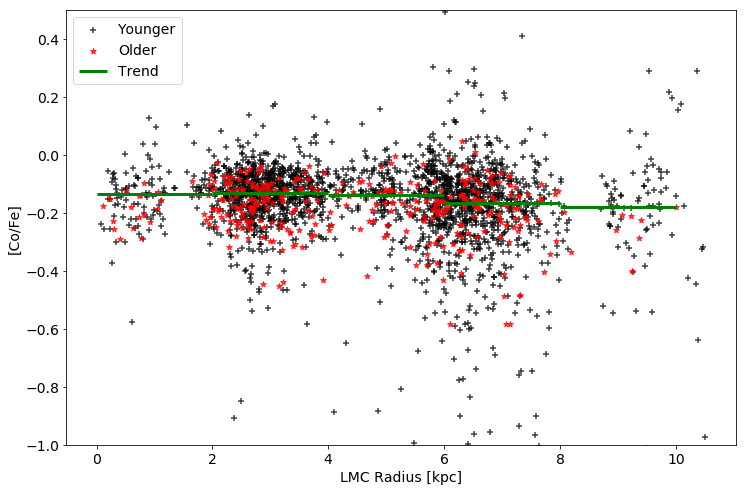

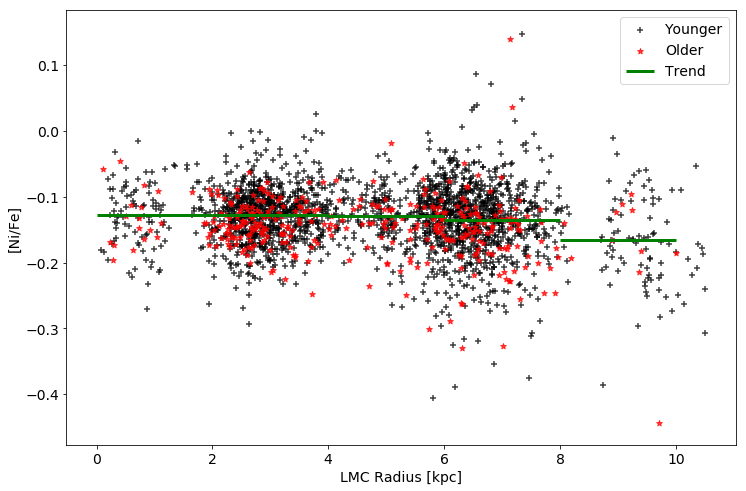

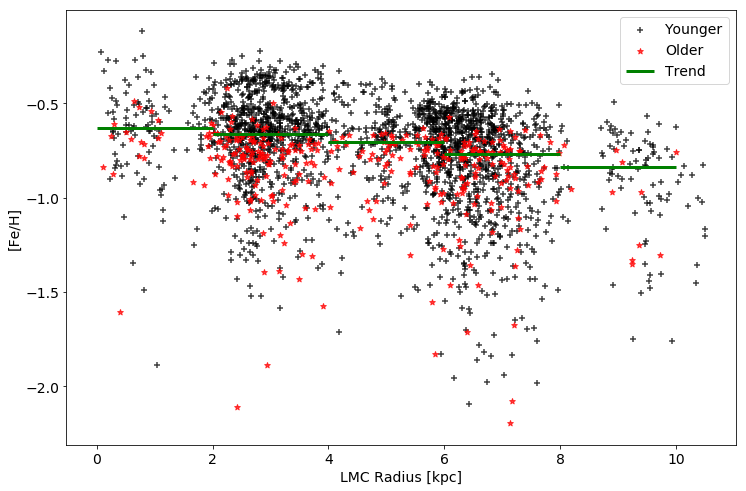

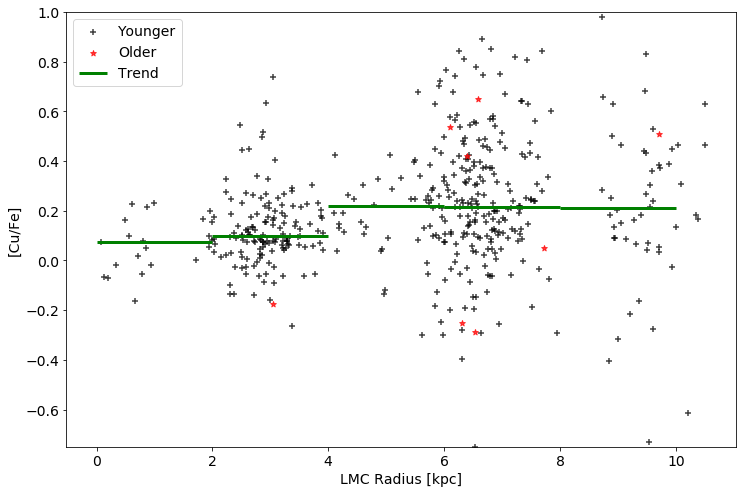

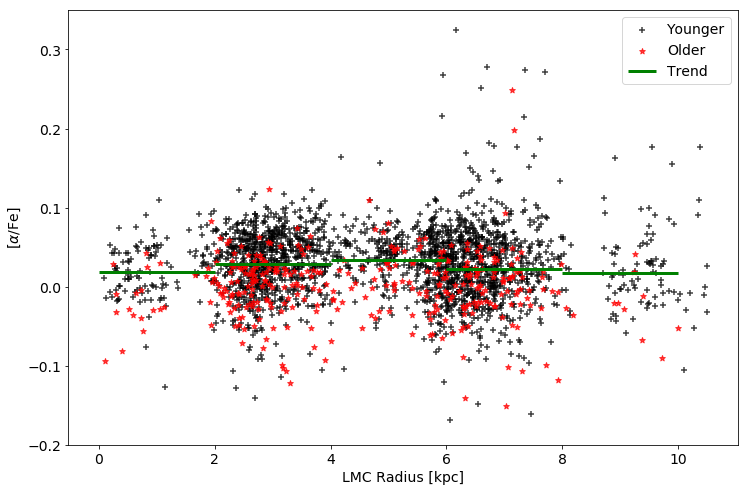

In [159]:
#####################################################
### Age-Abundance-Radius Relations For Two Groups ###
#####################################################

senex = np.where(parage > (10.13+np.max(devs)))
iuvenis = np.where(parage < (10.13+np.max(devs))) 

# senex = np.where(parage > 10.13)
# iuvenis = np.where(parage < 10.13)

import scipy.stats as st

### Carbon
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['C_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['C_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['C_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_c.jpg',bbox_inches='tight')
plt.show()

### Nitrogen
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['N_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['N_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['N_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_n.jpg',bbox_inches='tight')
plt.show()

### Oxygen
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['O_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['O_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['O_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_o.jpg',bbox_inches='tight')
plt.show()

### Sodium
clnna = np.where(clndr16['NA_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['NA_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['NA_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnna],clndr16['NA_FE'][clnna],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,1)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_na.jpg',bbox_inches='tight')
plt.show()

### Magnesium
clnmg = np.where(clndr16['MG_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['MG_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['MG_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnmg],clndr16['MG_FE'][clnmg],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[MG/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.2,0.5)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_mg.jpg',bbox_inches='tight')
plt.show()

### Aluminium
clnal = np.where(clndr16['AL_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['AL_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['AL_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnal],clndr16['AL_FE'][clnal],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.125)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_al.jpg',bbox_inches='tight')
plt.show()

### Silicon
clnsi = np.where(clndr16['SI_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['SI_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['SI_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnsi],clndr16['SI_FE'][clnsi],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.25,0.25)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_si.jpg',bbox_inches='tight')
plt.show()

### Potassium
clnk = np.where(clndr16['K_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['K_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['K_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnk],clndr16['K_FE'][clnk],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.5,1.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_k.jpg',bbox_inches='tight')
plt.show()

### Calcium
clnca = np.where(clndr16['CA_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CA_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CA_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnca],clndr16['CA_FE'][clnca],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.375,0.375)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_ca.jpg',bbox_inches='tight')
plt.show()

### Chromium
clncr = np.where(clndr16['CR_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CR_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CR_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncr],clndr16['CR_FE'][clncr],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1.0,0.75)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_cr.jpg',bbox_inches='tight')
plt.show()

### Maganese
clncr = np.where(clndr16['MN_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['MN_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['MN_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncr],clndr16['MN_FE'][clncr],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.5,0.125)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_mn.jpg',bbox_inches='tight')
plt.show()

### Cobalt
clnco = np.where(clndr16['CO_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CO_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CO_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnco],clndr16['CO_FE'][clnco],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-1,0.5)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_co.jpg',bbox_inches='tight')
plt.show()

### Nickel
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['NI_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['NI_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['NI_FE'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
#plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_ni.jpg',bbox_inches='tight')
plt.show()

### Iron
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['FE_H'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['FE_H'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['FE_H'],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Fe/H]')
plt.xlabel(r'LMC Radius [kpc]')
# plt.ylim(-1,0.2)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_fe.jpg',bbox_inches='tight')
plt.show()

### Copper
clncu = np.where(clndr16['CU_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],clndr16['CU_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],clndr16['CU_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncu],clndr16['CU_FE'][clncu],statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.75,1.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_cu.jpg',bbox_inches='tight')
plt.show()

### Alpha
#clncu = np.where(clndr16['CU_FE']>-100)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['LMCRAD'][iuvenis],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['LMCRAD'][senex],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[senex],marker='*',c='r',alpha=0.75,label='Older')
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.ylim(-0.2,0.35)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_alpha.jpg',bbox_inches='tight')
plt.show()


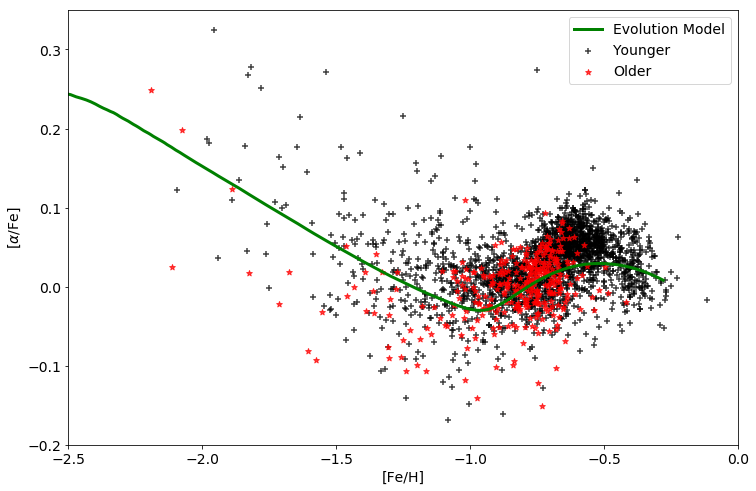

In [39]:
### Alpha to Iron plot
alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['FE_H'][iuvenis],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['FE_H'][senex],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[senex],marker='*',c='r',alpha=0.75,label='Older')
plt.plot(Chrismod['FeH'],alphachris,c='g',label='Evolution Model',lw=3)
#bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'[Fe/H]')
plt.ylim(-0.2,0.35)
plt.xlim(-2.5,0.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
plt.savefig('oldnewparsec_alphafe.jpg',bbox_inches='tight')
plt.show()

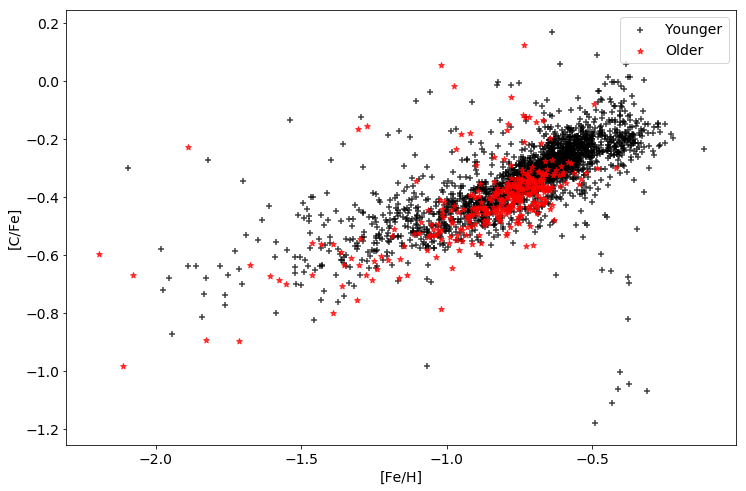

In [40]:
### Alpha to Iron plot
# alphachris = np.mean([Chrismod['OFe'],Chrismod['MgFe'],Chrismod['SiFe'],Chrismod['CaFe']],axis=0)
plt.figure(figsize=[12,8])
# plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=parage,cmap='gnuplot',alpha=0.75,label='Stars',vmax=14)
plt.scatter(clndr16['FE_H'][iuvenis],clndr16['C_FE'][iuvenis],marker='+',c='k',alpha=0.75,label='Younger')
plt.scatter(clndr16['FE_H'][senex],clndr16['C_FE'][senex],marker='*',c='r',alpha=0.75,label='Older')
# plt.plot(Chrismod['FeH'],alphachris,c='g',label='Evolution Model',lw=3)
#bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H']),statistic='median', bins=[0,2,4,6,8,10])
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=3.0,label='Trend')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'[Fe/H]')
# plt.ylim(-0.2,0.35)
# plt.xlim(-2.5,0.0)
# plt.title(r'Color as Age [Gyr]')
plt.legend()
# plt.savefig('oldnewparsec_alphafe.jpg',bbox_inches='tight')
plt.show()

In [41]:
len(np.squeeze(senex))/len(parage)

0.1446229913473424

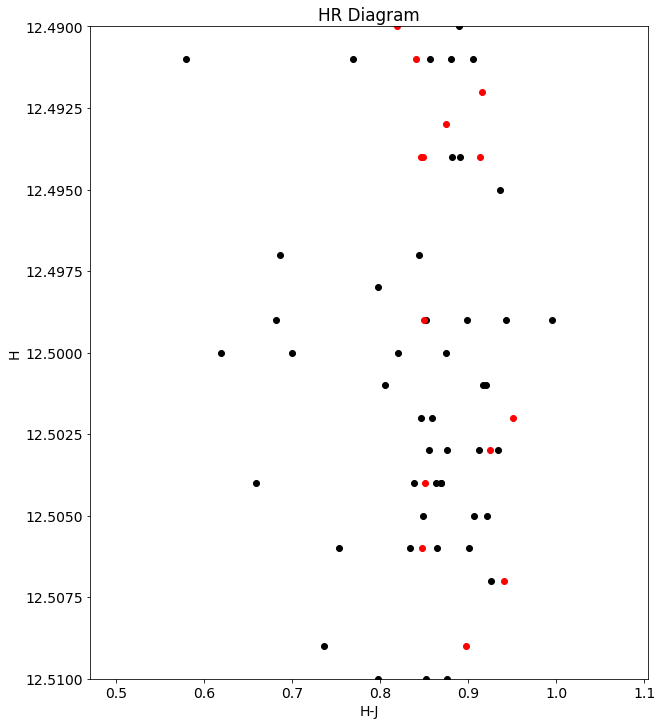

In [42]:
##################
### HR Diagram ###
##################

plt.figure(figsize=[10,12])
plt.scatter(-1*(clndr16['H']-clndr16['J'])[iuvenis],clndr16['H'][iuvenis],c='k')
plt.scatter(-1*(clndr16['H']-clndr16['J'])[senex],clndr16['H'][senex],c='r')
plt.xlabel(r'H-J')
plt.ylabel(r'H')
# plt.ylim(14.5,12)
plt.ylim(12.5+0.01,12.5-0.01)
# plt.xlim(0.7,0.95)
plt.title(r'HR Diagram')
plt.show()

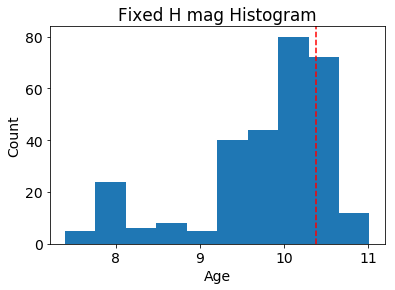

In [43]:
######################
### Pick magnitude ###
######################

mag = np.where((clndr16['H']>=12.5-0.05)&(clndr16['H']<=12.5+0.05))

old = np.where(parage[mag] > 10.13+max(devs))
new = np.where(parage[mag] < 10.13+max(devs))

plt.hist(parage[mag])
plt.axvline(10.13+max(devs),c='red',linestyle='--')
plt.xlabel(r'Age')
plt.ylabel(r'Count')
plt.title(r'Fixed H mag Histogram')
plt.show()

magcut = clndr16[mag]
magage = parage[mag]

### Color bins
# n = np.absolute(max((clndr16['H']-clndr16['J'])[mag])-min((clndr16['H']-clndr16['J'])[mag]))/4.0
# bin1 = np.where((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+n)
# bin2 = np.where(((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+n)&\
#                 ((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+2.0*n))
# bin3 = np.where(((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+2.0*n)&\
#                 ((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+3.0*n))
# bin4 = np.where((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+3.0*n)

n = np.absolute(0.8-1.0)/4.0
bin1 = np.where((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+n)
bin2 = np.where(((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+n)&\
                ((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+2.0*n))
bin3 = np.where(((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+2.0*n)&\
                ((clndr16['H']-clndr16['J'])[mag]<min((clndr16['H']-clndr16['J'])[mag])+3.0*n))
bin4 = np.where((clndr16['H']-clndr16['J'])[mag]>min((clndr16['H']-clndr16['J'])[mag])+3.0*n)

### tag stars that are two old
old1 = np.where(magage[bin1] > 10.13 + max(devs))
old2 = np.where(magage[bin2] > 10.13 + max(devs))
old3 = np.where(magage[bin3] > 10.13 + max(devs))
old4 = np.where(magage[bin4] > 10.13 + max(devs))
new1 = np.where(magage[bin1] < 10.13 + max(devs))
new2 = np.where(magage[bin2] < 10.13 + max(devs))
new3 = np.where(magage[bin3] < 10.13 + max(devs))
new4 = np.where(magage[bin4] < 10.13 + max(devs))


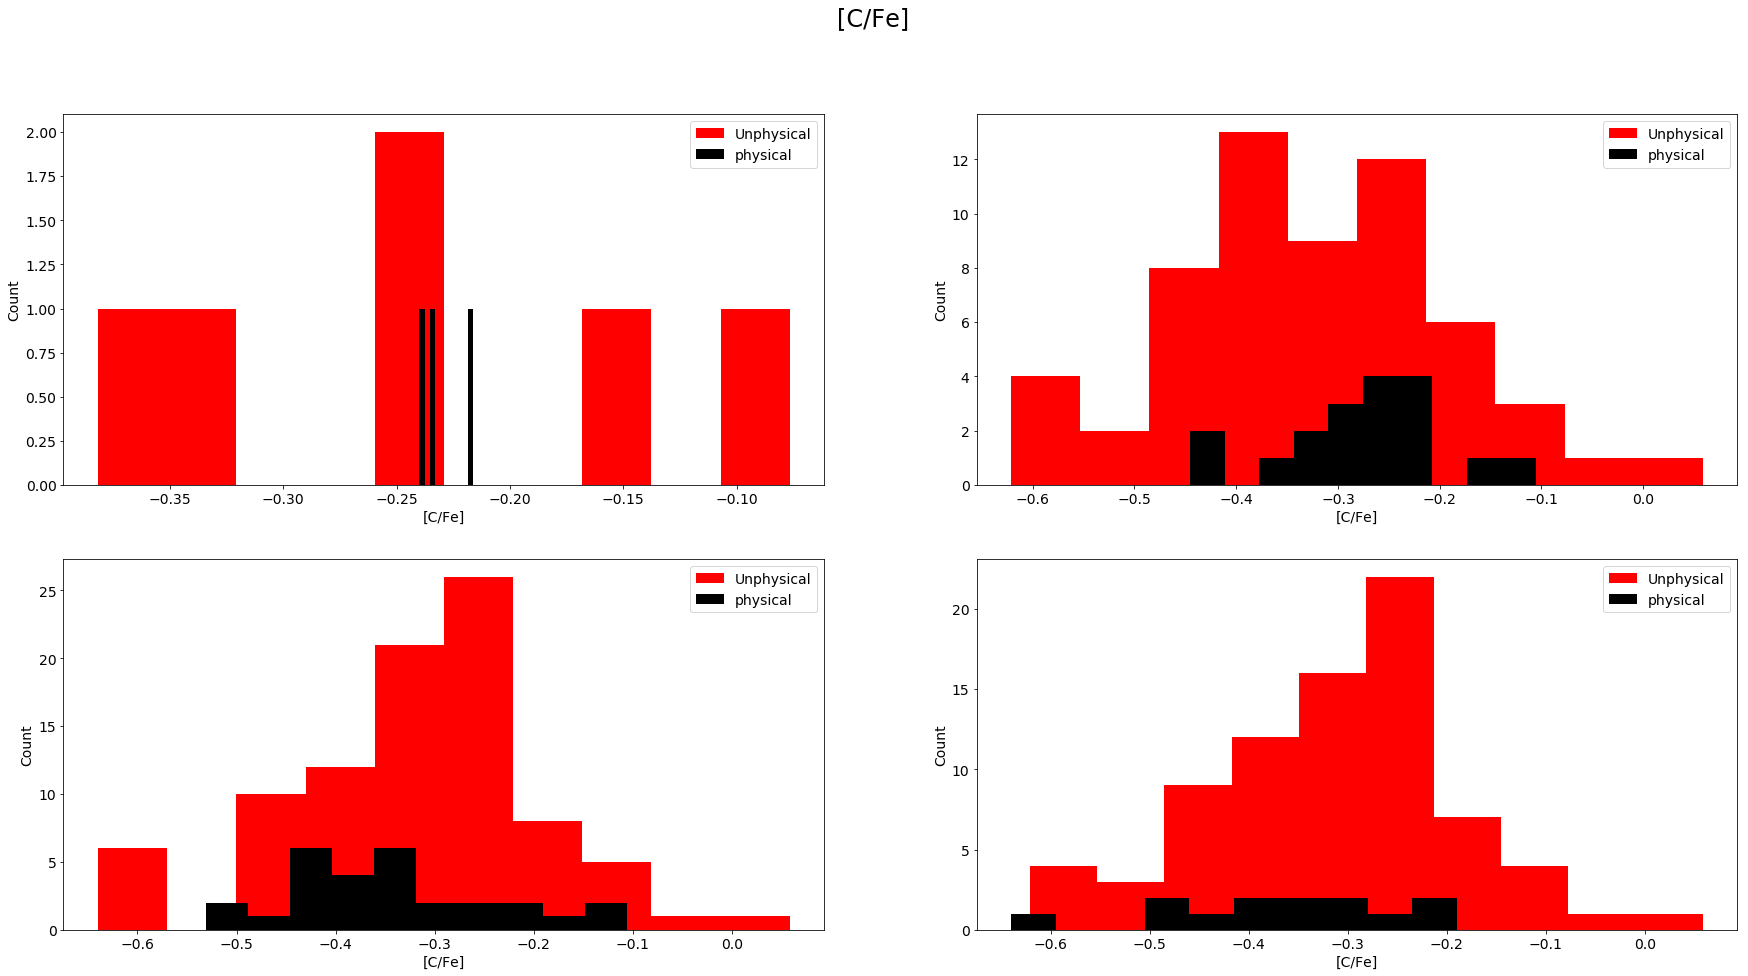

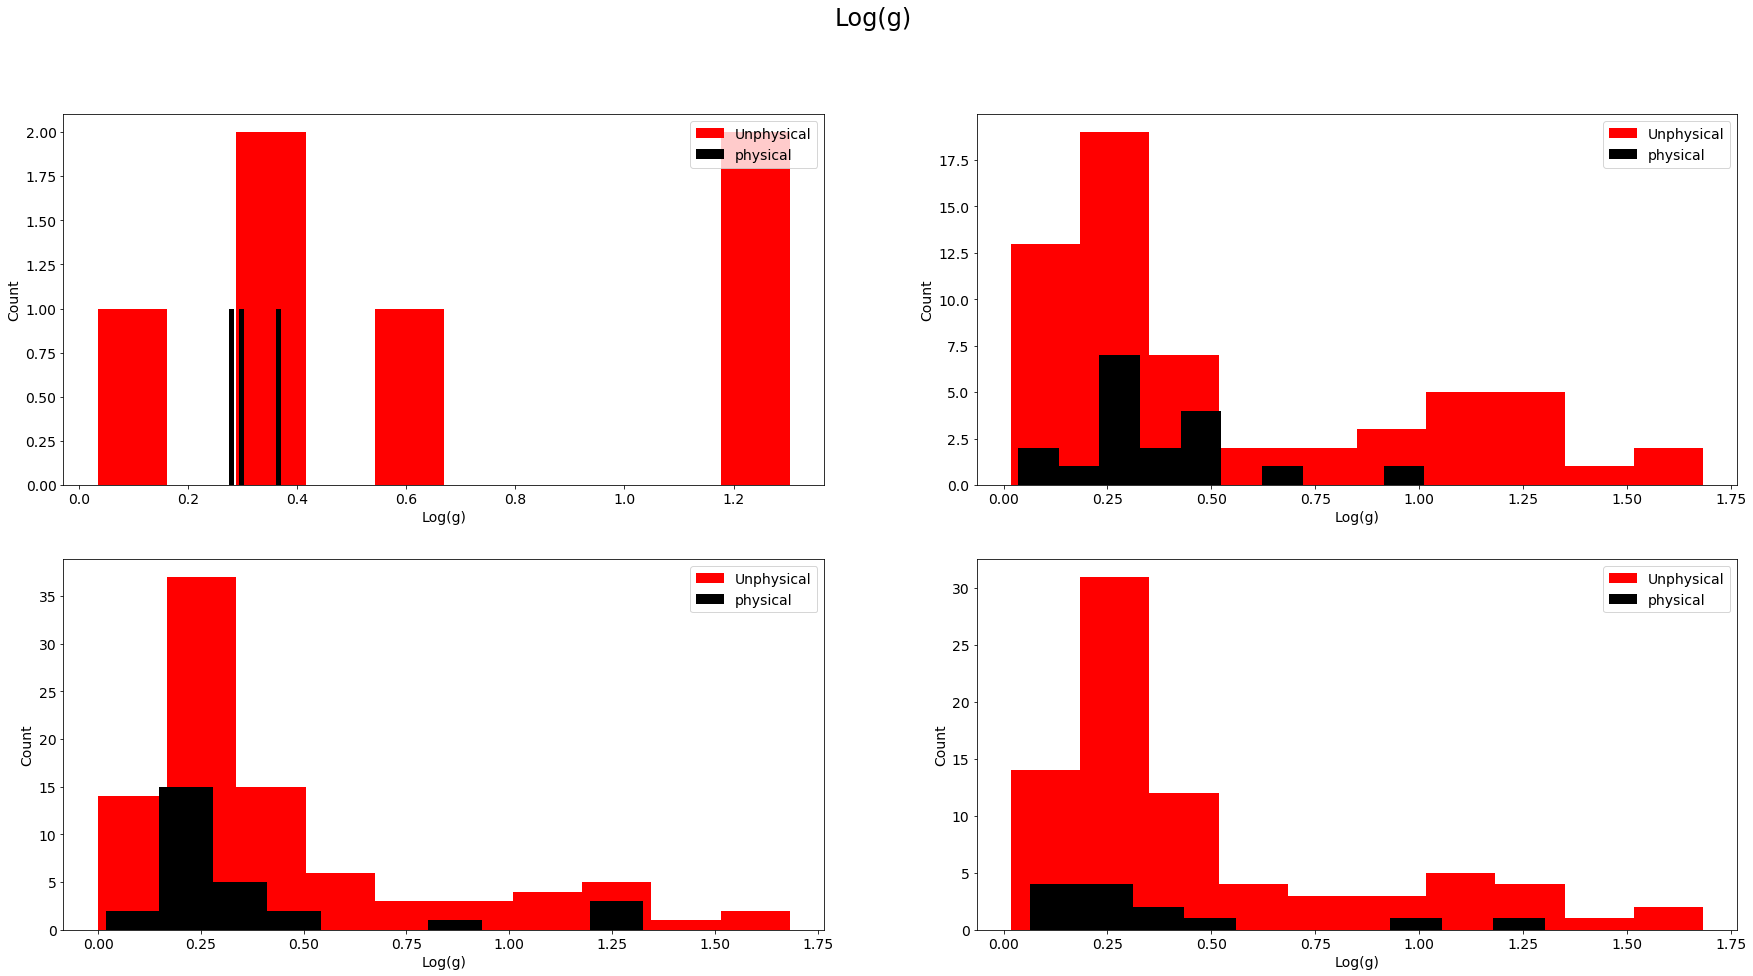

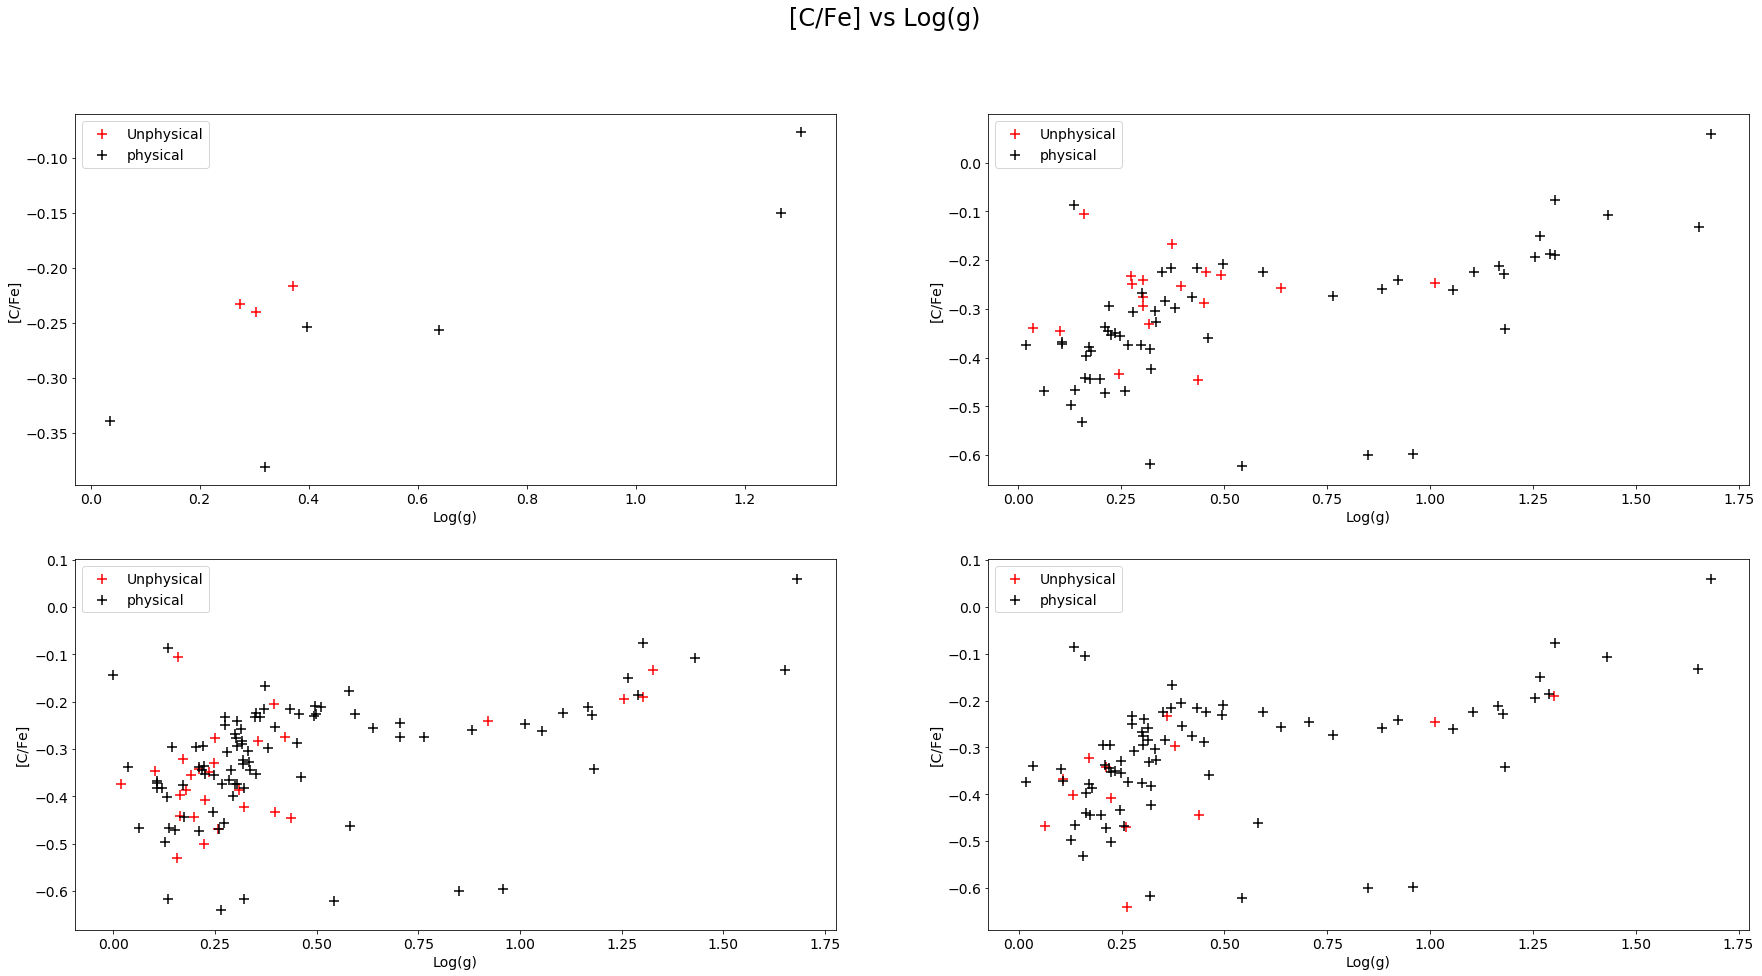

In [44]:
### Carbon
# f, ax = plt.subplots(2,2, facecolor='w',figsize=(30,15))
# p = ax[0,0].scatter(magcut['FE_H'][old1],magcut['C_FE'][old1],marker='+',c='r',label='Unphysical',s=100)
# ax[0,0].scatter(magcut['FE_H'][new1],magcut['C_FE'][new1],marker='+',c='k',label='physical',s=100)
# # ax[0,0].set_title('Color as Age',fontsize=18)
# ax[0,0].set_xlabel('[Fe/H]')
# ax[0,0].legend(loc='upper left')
# ax[0,0].set_ylabel('[C/Fe]')
# q = ax[0,1].scatter(magcut['FE_H'][old2],magcut['C_FE'][old2],marker='+',c='r',label='Unphysical',s=100)
# ax[0,1].scatter(magcut['FE_H'][new2],magcut['C_FE'][new2],marker='+',c='k',label='physical',s=100)
# # ax[0,1].set_title('Color as Age',fontsize=18)
# ax[0,1].set_xlabel('[Fe/H]')
# ax[0,1].legend(loc='upper left')
# ax[0,1].set_ylabel('[C/Fe]')
# r = ax[1,0].scatter(magcut['FE_H'][old3],magcut['C_FE'][old3],marker='+',c='r',label='Unphysical',s=100)
# ax[1,0].scatter(magcut['FE_H'][new3],magcut['C_FE'][new3],marker='+',c='k',label='physical',s=100)
# # ax[1,0].set_title('Color as Age',fontsize=18)
# ax[1,0].set_xlabel('[Fe/H]')
# ax[1,0].legend(loc='upper left')
# ax[1,0].set_ylabel('[C/Fe]')
# s = ax[1,1].scatter(magcut['FE_H'][old4],magcut['C_FE'][old4],marker='+',c='r',label='Unphysical',s=100)
# ax[1,1].scatter(magcut['FE_H'][new4],magcut['C_FE'][new4],marker='+',c='k',label='physical',s=100)
# # ax[1,1].set_title('Color as Age',fontsize=18)
# ax[1,1].set_xlabel('[Fe/H]')
# ax[1,1].legend(loc='upper left')
# ax[1,1].set_ylabel('[C/Fe]')
# f.suptitle(r'[C/Fe] vs [Fe/H]',fontsize=24)
# plt.show()

### Carbon
f, ax = plt.subplots(2,2, facecolor='w',figsize=(30,15))
p = ax[0,0].hist(magcut['C_FE'][new1],color='r',label='Unphysical')
ax[0,0].hist(magcut['C_FE'][old1],color='k',label='physical')
ax[0,0].set_xlabel('[C/Fe]')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('Count')
q = ax[0,1].hist(magcut['C_FE'][new2],color='r',label='Unphysical')
ax[0,1].hist(magcut['C_FE'][old2],color='k',label='physical')
ax[0,1].set_xlabel('[C/Fe]')
ax[0,1].legend(loc='upper right')
ax[0,1].set_ylabel('Count')
p = ax[1,0].hist(magcut['C_FE'][new3],color='r',label='Unphysical')
ax[1,0].hist(magcut['C_FE'][old3],color='k',label='physical')
ax[1,0].set_xlabel('[C/Fe]')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('Count')
p = ax[1,1].hist(magcut['C_FE'][new4],color='r',label='Unphysical')
ax[1,1].hist(magcut['C_FE'][old4],color='k',label='physical')
ax[1,1].set_xlabel('[C/Fe]')
ax[1,1].legend(loc='upper right')
ax[1,1].set_ylabel('Count')
f.suptitle(r'[C/Fe]',fontsize=24)
plt.show()

### Log(g)
f, ax = plt.subplots(2,2, facecolor='w',figsize=(30,15))
p = ax[0,0].hist(magcut['LOGG'][new1],color='r',label='Unphysical')
ax[0,0].hist(magcut['LOGG'][old1],color='k',label='physical')
ax[0,0].set_xlabel('Log(g)')
ax[0,0].legend(loc='upper right')
ax[0,0].set_ylabel('Count')
q = ax[0,1].hist(magcut['LOGG'][new2],color='r',label='Unphysical')
ax[0,1].hist(magcut['LOGG'][old2],color='k',label='physical')
ax[0,1].set_xlabel('Log(g)')
ax[0,1].legend(loc='upper right')
ax[0,1].set_ylabel('Count')
p = ax[1,0].hist(magcut['LOGG'][new3],color='r',label='Unphysical')
ax[1,0].hist(magcut['LOGG'][old3],color='k',label='physical')
ax[1,0].set_xlabel('Log(g)')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('Count')
p = ax[1,1].hist(magcut['LOGG'][new4],color='r',label='Unphysical')
ax[1,1].hist(magcut['LOGG'][old4],color='k',label='physical')
ax[1,1].set_xlabel('Log(g)')
ax[1,1].legend(loc='upper right')
ax[1,1].set_ylabel('Count')
f.suptitle(r'Log(g)',fontsize=24)
plt.show()

### Carbon and Log(g) together
f, ax = plt.subplots(2,2, facecolor='w',figsize=(30,15))
p = ax[0,0].scatter(magcut['LOGG'][old1],magcut['C_FE'][old1],marker='+',c='r',label='Unphysical',s=100)
ax[0,0].scatter(magcut['LOGG'][new1],magcut['C_FE'][new1],marker='+',c='k',label='physical',s=100)
# ax[0,0].set_title('Color as Age',fontsize=18)
ax[0,0].set_xlabel('Log(g)')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('[C/Fe]')
q = ax[0,1].scatter(magcut['LOGG'][old2],magcut['C_FE'][old2],marker='+',c='r',label='Unphysical',s=100)
ax[0,1].scatter(magcut['LOGG'][new2],magcut['C_FE'][new2],marker='+',c='k',label='physical',s=100)
# ax[0,1].set_title('Color as Age',fontsize=18)
ax[0,1].set_xlabel('Log(g)')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('[C/Fe]')
r = ax[1,0].scatter(magcut['LOGG'][old3],magcut['C_FE'][old3],marker='+',c='r',label='Unphysical',s=100)
ax[1,0].scatter(magcut['LOGG'][new3],magcut['C_FE'][new3],marker='+',c='k',label='physical',s=100)
# ax[1,0].set_title('Color as Age',fontsize=18)
ax[1,0].set_xlabel('Log(g)')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('[C/Fe]')
s = ax[1,1].scatter(magcut['LOGG'][old4],magcut['C_FE'][old4],marker='+',c='r',label='Unphysical',s=100)
ax[1,1].scatter(magcut['LOGG'][new4],magcut['C_FE'][new4],marker='+',c='k',label='physical',s=100)
# ax[1,1].set_title('Color as Age',fontsize=18)
ax[1,1].set_xlabel('Log(g)')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('[C/Fe]')
f.suptitle(r'[C/Fe] vs Log(g)',fontsize=24)
plt.show()

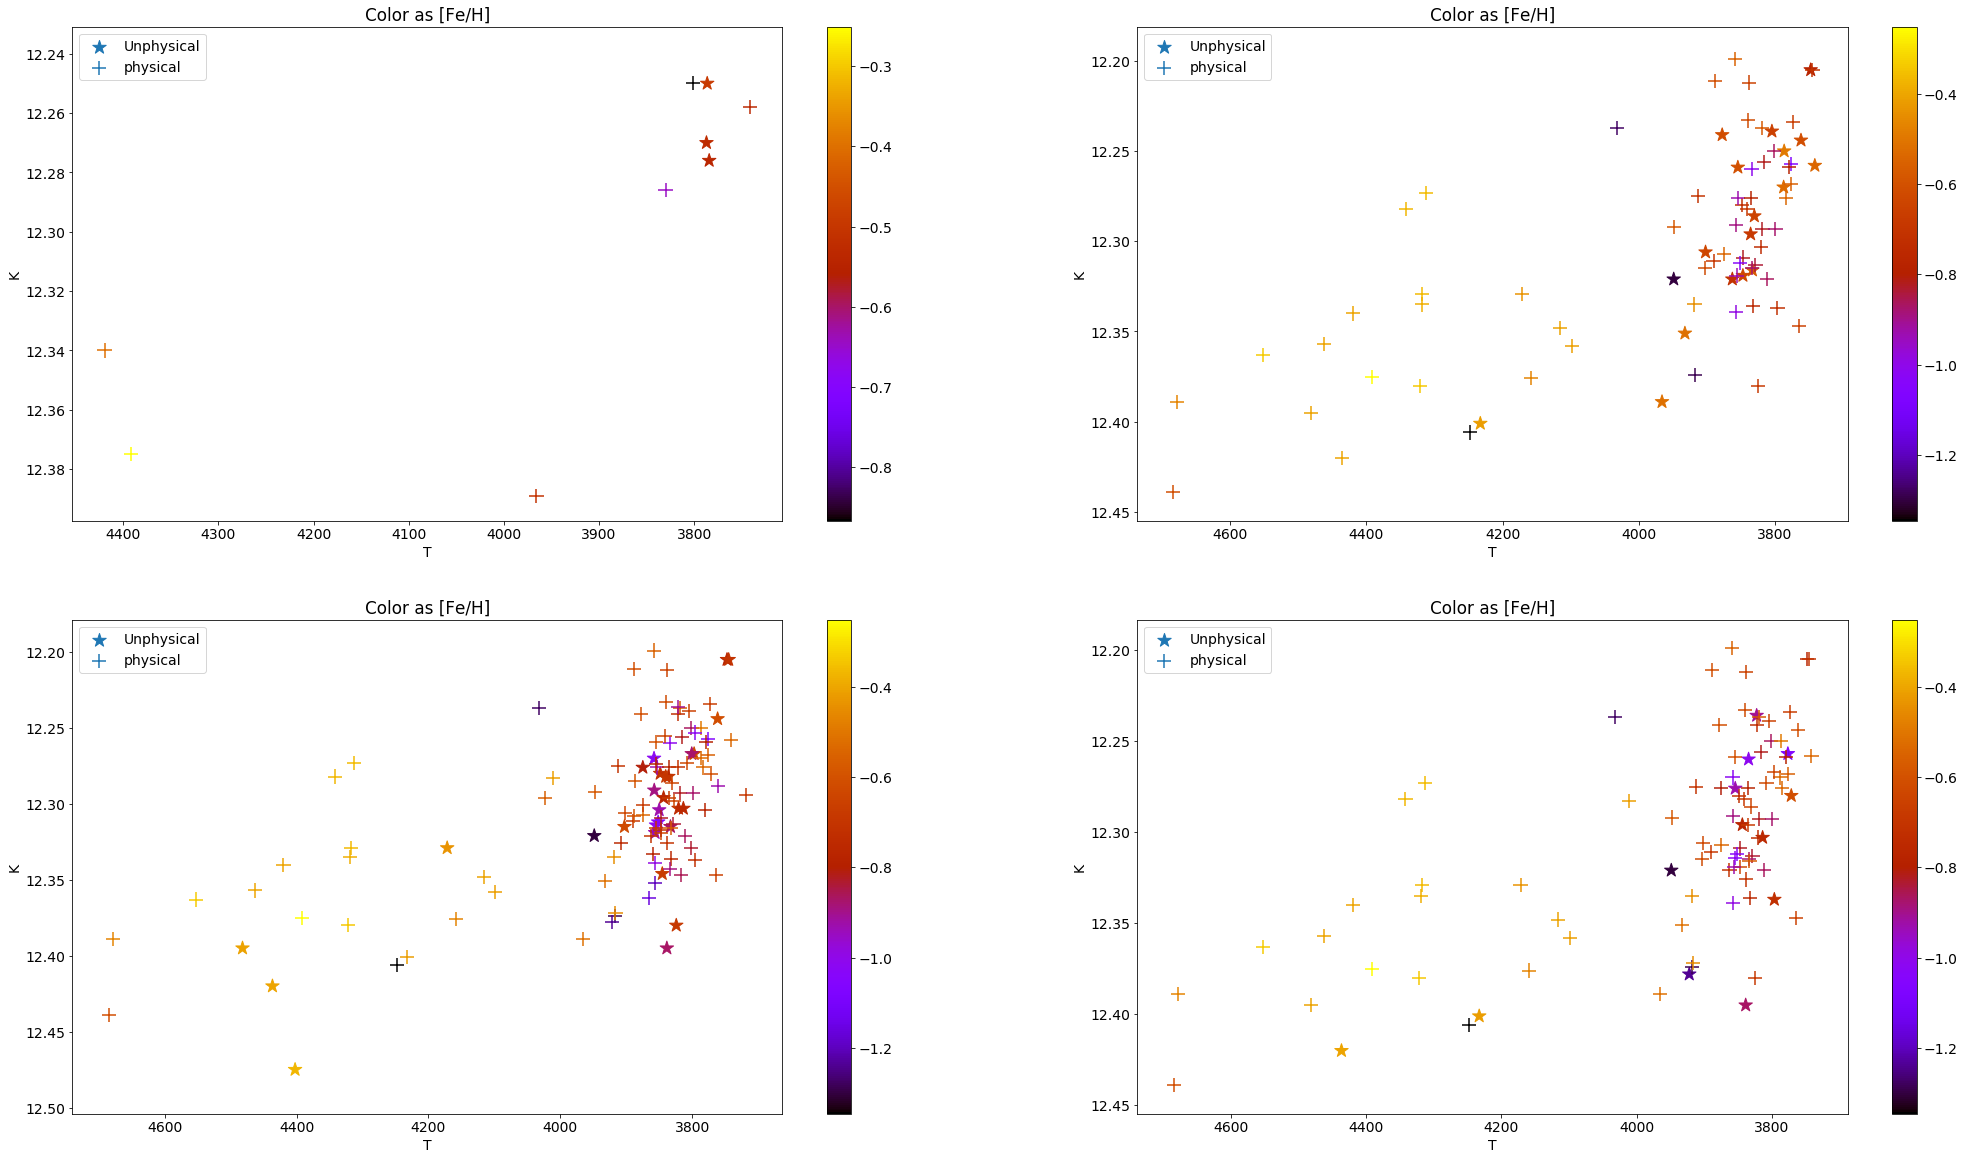

In [61]:
### HR T, K, Marker as physical

col = 'gnuplot'

f, ax = plt.subplots(2,2, facecolor='w',figsize=(35,20))
p=ax[0,0].scatter(magcut['TEFF'][old1],magcut['K'][old1],marker='*',c=magcut['FE_H'][old1],label='Unphysical',\
                s=200,cmap=col,vmax=max(magcut['FE_H'][new1]),vmin=min(magcut['FE_H'][new1]))
ax[0,0].scatter(magcut['TEFF'][new1],magcut['K'][new1],marker='+',c=magcut['FE_H'][new1],label='physical',\
                s=200,cmap=col)
ax[0,0].set_xlabel('T')
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('K')
ax[0,0].invert_xaxis()
ax[0,0].invert_yaxis()
ax[0,0].title.set_text(r'Color as [Fe/H]')
q=ax[0,1].scatter(magcut['TEFF'][old2],magcut['K'][old2],marker='*',c=magcut['FE_H'][old2],label='Unphysical',\
                s=200,cmap=col,vmax=max(magcut['FE_H'][new2]),vmin=min(magcut['FE_H'][new2]))
ax[0,1].scatter(magcut['TEFF'][new2],magcut['K'][new2],marker='+',c=magcut['FE_H'][new2],label='physical',\
                s=200,cmap=col)
ax[0,1].set_xlabel('T')
ax[0,1].legend(loc='upper left')
ax[0,1].set_ylabel('K')
ax[0,1].invert_xaxis()
ax[0,1].invert_yaxis()
ax[0,1].title.set_text(r'Color as [Fe/H]')
r=ax[1,0].scatter(magcut['TEFF'][old3],magcut['K'][old3],marker='*',c=magcut['FE_H'][old3],label='Unphysical',\
                s=200,cmap=col,vmax=max(magcut['FE_H'][new3]),vmin=min(magcut['FE_H'][new3]))
ax[1,0].scatter(magcut['TEFF'][new3],magcut['K'][new3],marker='+',c=magcut['FE_H'][new3],label='physical',\
                s=200,cmap=col)
ax[1,0].set_xlabel('T')
ax[1,0].legend(loc='upper left')
ax[1,0].set_ylabel('K')
ax[1,0].invert_xaxis()
ax[1,0].invert_yaxis()
ax[1,0].title.set_text(r'Color as [Fe/H]')
s=ax[1,1].scatter(magcut['TEFF'][old4],magcut['K'][old4],marker='*',c=magcut['FE_H'][old4],label='Unphysical',\
                s=200,cmap=col,vmax=max(magcut['FE_H'][new4]),vmin=min(magcut['FE_H'][new4]))
ax[1,1].scatter(magcut['TEFF'][new4],magcut['K'][new4],marker='+',c=magcut['FE_H'][new4],label='physical',\
                s=200,cmap=col)
ax[1,1].set_xlabel('T')
ax[1,1].legend(loc='upper left')
ax[1,1].set_ylabel('K')
ax[1,1].invert_xaxis()
ax[1,1].invert_yaxis()
ax[1,1].title.set_text(r'Color as [Fe/H]')

f.colorbar(p,ax=ax[0,0])
f.colorbar(q,ax=ax[0,1])
f.colorbar(r,ax=ax[1,0])
f.colorbar(s,ax=ax[1,1])

plt.show()

In [115]:
# print(np.where(magcut['TEFF'][new4]>=3800))
print(np.where((magcut['K'][new4]>=12.375)&(magcut['K'][new4]<=12.40)&(magcut['TEFF'][new4]>=3800)&(magcut['TEFF'][new4]<=4000)))
print(magcut['K'][new4][8])
print(magcut['K'][new4][45])

(array([ 8, 45]),)
12.389
12.38


In [116]:
magcut['APOGEE_ID'][new4][45]

'2M05481203-6823387'

In [47]:
# np.where(magcut['K'][new1]==min(magcut['K'][new1]))
# magcut['FE_H'][new1][3]
# max(magcut['K'][new1])

In [48]:
# plt.hist(magcut['FE_H'][new4],alpha=0.75)
# plt.hist(magcut['FE_H'][old4],alpha=0.75)
# vmax=max(magcut['FE_H'][new1]),vmin=min(magcut['FE_H'][new1])

In [49]:
# plt.hist(np.log10(clndr16['TEFF'][new]))
# plt.hist(np.log10(clndr16['TEFF'][old]))
# plt.show()

# plt.hist(clndr16['K'][new])
# plt.hist(clndr16['K'][old])
# plt.show()

# plt.hist(clndr16['FE_H'][new])
# plt.hist(clndr16['FE_H'][old])
# plt.show()

# plt.hist(clndr16['LOGG'][new])
# plt.hist(clndr16['LOGG'][old])
# plt.show()

In [50]:
# plt.hist(np.multiply(clndr16['LOGG'],clndr16['K'])[new])
# plt.hist(np.multiply(clndr16['LOGG'],clndr16['K'])[old])
# plt.show()

# plt.hist(np.multiply(clndr16['LOGG'],clndr16['FE_H'])[new])
# plt.hist(np.multiply(clndr16['LOGG'],clndr16['FE_H'])[old])
# plt.show()

# plt.hist(clndr16['K'][new]**2)
# plt.hist(clndr16['K'][old]**2)
# plt.show()

# plt.hist(clndr16['LOGG'][new]**2)
# plt.hist(clndr16['LOGG'][old]**2)
# plt.show()

In [51]:
w,v = np.linalg.eig(np.cov([np.log10(clndr16['TEFF']),clndr16['K'],clndr16['FE_H'],clndr16['LOGG']]).T)
print(w)
print(v)

[3.31606408e-01 6.35289877e-05 9.60979935e-02 3.90755515e-02]
[[ 0.02538802  0.99850953 -0.01915517 -0.04435361]
 [ 0.81385327  0.00658497  0.35259828  0.46181592]
 [-0.04214414  0.01551096 -0.7569212   0.65196133]
 [ 0.57898374 -0.05191111 -0.54988892 -0.59975431]]


In [52]:
print(bin1)
print(old1)
print(new1)

(array([  2,  23,  47,  96, 123, 145, 149, 180, 186]),)
(array([0, 4, 7]),)
(array([1, 2, 3, 5, 6, 8]),)


In [53]:
print(bin2)

(array([  4,  10,  22,  30,  32,  60,  61,  64,  66,  68,  71,  74,  78,
        79,  80,  82,  83,  86,  93,  94,  95,  99, 100, 102, 104, 111,
       113, 118, 120, 122, 124, 127, 128, 130, 132, 137, 138, 144, 150,
       152, 163, 170, 172, 176, 177, 178, 185, 187, 188, 189, 190, 195,
       197, 199, 203, 205, 206, 209, 218, 219, 227, 237, 239, 241, 243,
       245, 247, 248, 249, 250, 251, 254, 266, 276, 281, 291, 295]),)


In [54]:
print(bin3)

(array([  0,   5,   6,   7,  11,  12,  13,  14,  15,  16,  17,  18,  20,
        24,  25,  36,  38,  39,  42,  43,  44,  51,  53,  55,  56,  57,
        62,  63,  65,  67,  69,  70,  73,  75,  77,  81,  84,  87,  88,
        90,  97,  98, 101, 105, 106, 107, 109, 110, 112, 114, 115, 116,
       117, 119, 125, 126, 133, 134, 140, 142, 147, 151, 155, 159, 162,
       164, 167, 168, 169, 173, 175, 181, 182, 184, 191, 192, 196, 198,
       200, 201, 202, 210, 212, 221, 223, 224, 226, 229, 232, 246, 253,
       255, 256, 258, 261, 262, 263, 264, 265, 267, 268, 269, 270, 272,
       273, 274, 275, 277, 278, 279, 282, 284, 288, 289, 290, 292, 293,
       294]),)


In [55]:
print(bin4)

(array([  1,   3,   8,   9,  19,  21,  26,  27,  28,  29,  31,  33,  34,
        35,  37,  40,  41,  45,  46,  48,  49,  50,  52,  54,  58,  59,
        72,  76,  85,  89,  91,  92, 103, 108, 121, 129, 131, 135, 136,
       139, 141, 143, 146, 148, 153, 154, 156, 157, 158, 160, 161, 165,
       166, 171, 174, 179, 183, 193, 194, 204, 207, 208, 211, 213, 214,
       215, 216, 217, 220, 222, 225, 228, 230, 231, 233, 234, 235, 236,
       238, 240, 242, 244, 252, 257, 259, 260, 271, 280, 283, 285, 286,
       287]),)


In [56]:
clndr16.columns

ColDefs(
    name = 'APSTAR_ID'; format = '46A'
    name = 'TARGET_ID'; format = '39A'
    name = 'ASPCAP_ID'; format = '56A'
    name = 'FILE'; format = '34A'
    name = 'APOGEE_ID'; format = '18A'
    name = 'TELESCOPE'; format = '6A'
    name = 'LOCATION_ID'; format = 'J'
    name = 'FIELD'; format = '5A'
    name = 'J'; format = 'E'
    name = 'J_ERR'; format = 'E'
    name = 'H'; format = 'E'
    name = 'H_ERR'; format = 'E'
    name = 'K'; format = 'E'
    name = 'K_ERR'; format = 'E'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'GLON'; format = 'D'
    name = 'GLAT'; format = 'D'
    name = 'APOGEE_TARGET1'; format = 'J'
    name = 'APOGEE_TARGET2'; format = 'J'
    name = 'APOGEE_TARGET3'; format = 'J'
    name = 'APOGEE2_TARGET1'; format = 'J'
    name = 'APOGEE2_TARGET2'; format = 'J'
    name = 'APOGEE2_TARGET3'; format = 'J'
    name = 'TARGFLAGS'; format = '105A'
    name = 'SURVEY'; format = '8A'
    name = 'PROGRAMNAME'; format = '18A'
    name

-0.320155
0.08277002
-0.40958
0.056580007


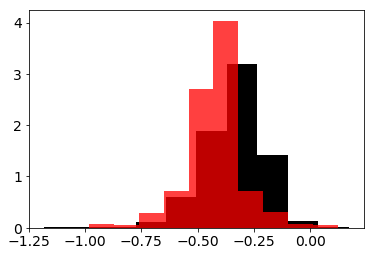

In [57]:
plt.hist(clndr16['C_FE'][iuvenis],color='black',density=True)
plt.hist(clndr16['C_FE'][senex],color='red',density=True,alpha=0.75)

print(np.median(clndr16['C_FE'][iuvenis]))
print(mad(clndr16['C_FE'][iuvenis]))
print(np.median(clndr16['C_FE'][senex]))
print(mad(clndr16['C_FE'][senex]))

0.042627007
0.025860965
0.0065509975
0.025724024


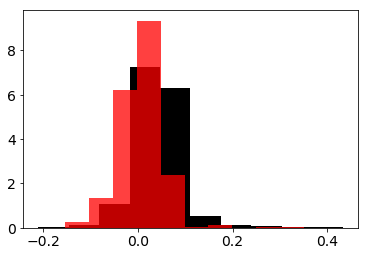

In [58]:
plt.hist(clndr16['O_FE'][iuvenis],color='black',density=True)
plt.hist(clndr16['O_FE'][senex],color='red',density=True,alpha=0.75)

print(np.median(clndr16['O_FE'][iuvenis]))
print(mad(clndr16['O_FE'][iuvenis]))
print(np.median(clndr16['O_FE'][senex]))
print(mad(clndr16['O_FE'][senex]))


-0.68487155
0.13701499
-0.7855815
0.091609955


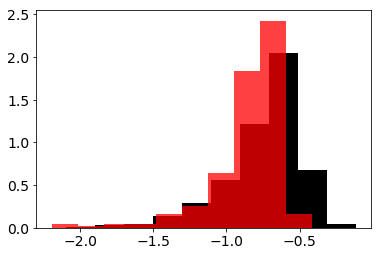

In [59]:
plt.hist(clndr16['FE_H'][iuvenis],color='black',density=True)
plt.hist(clndr16['FE_H'][senex],color='red',density=True,alpha=0.75)

print(np.median(clndr16['FE_H'][iuvenis]))
print(mad(clndr16['FE_H'][iuvenis]))
print(np.median(clndr16['FE_H'][senex]))
print(mad(clndr16['FE_H'][senex]))

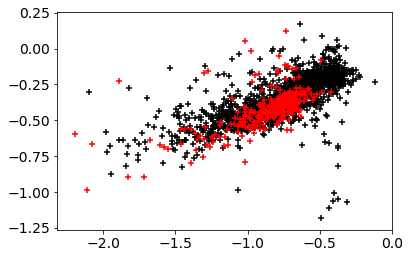

In [60]:
plt.scatter(clndr16['FE_H'][iuvenis],clndr16['C_FE'][iuvenis],c='k',marker='+')
plt.scatter(clndr16['FE_H'][senex],clndr16['C_FE'][senex],c='r',marker='+')

In [118]:
star = np.where(clndr16['APOGEE_ID']=='2M05344888-6930585')


(array([98]),)


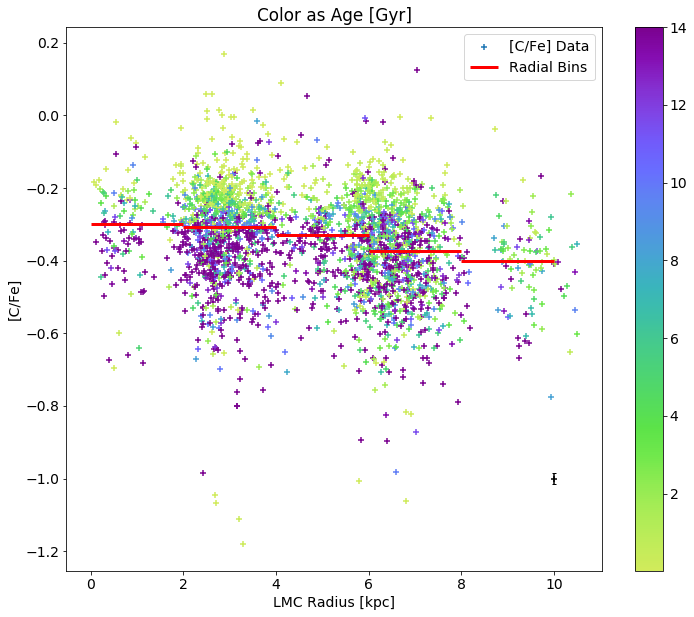

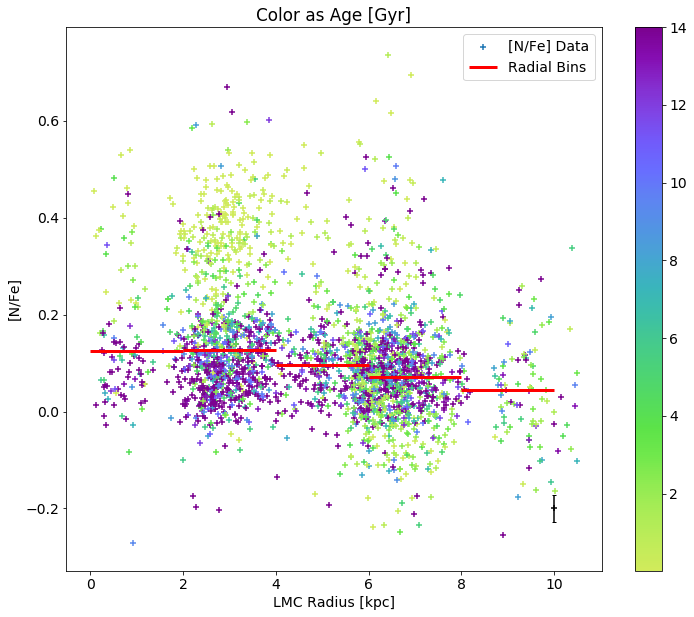

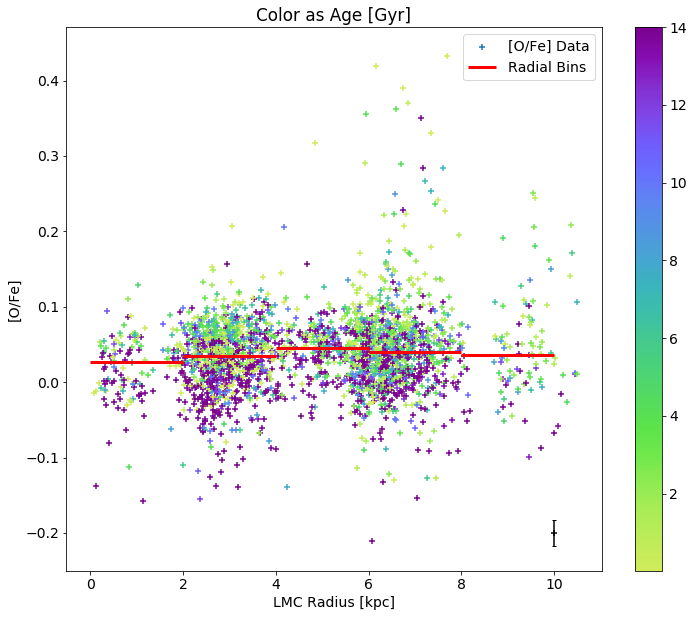

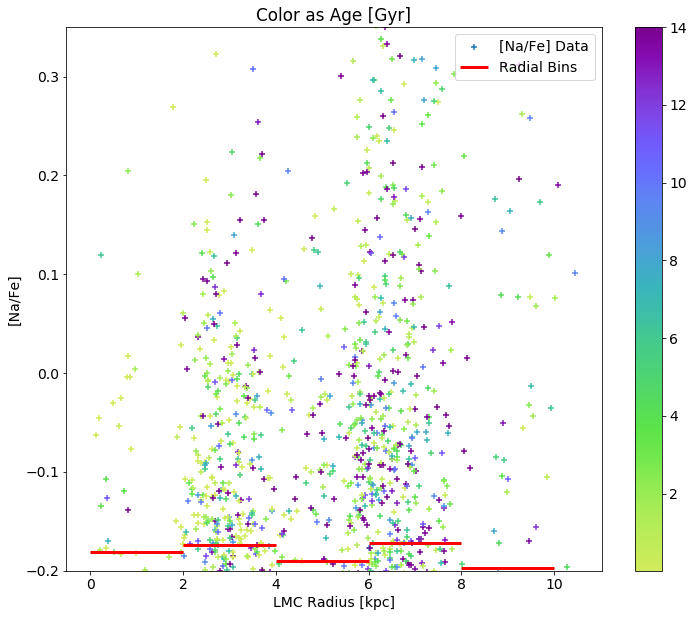

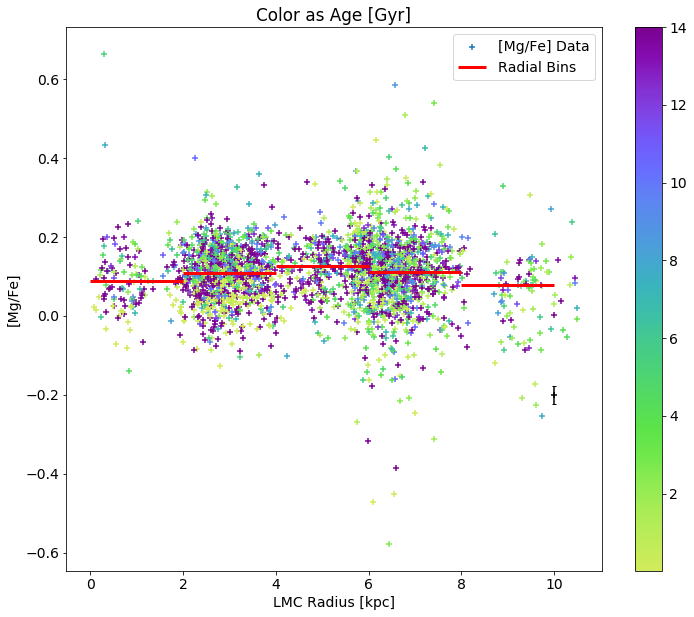

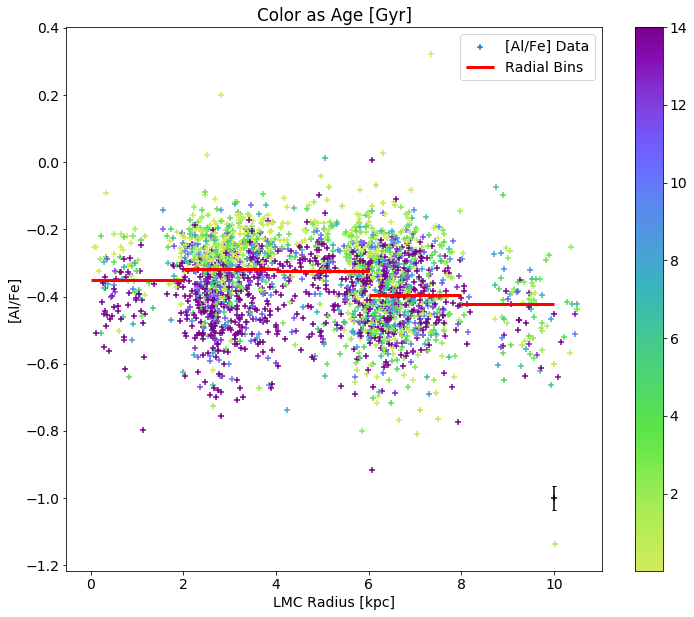

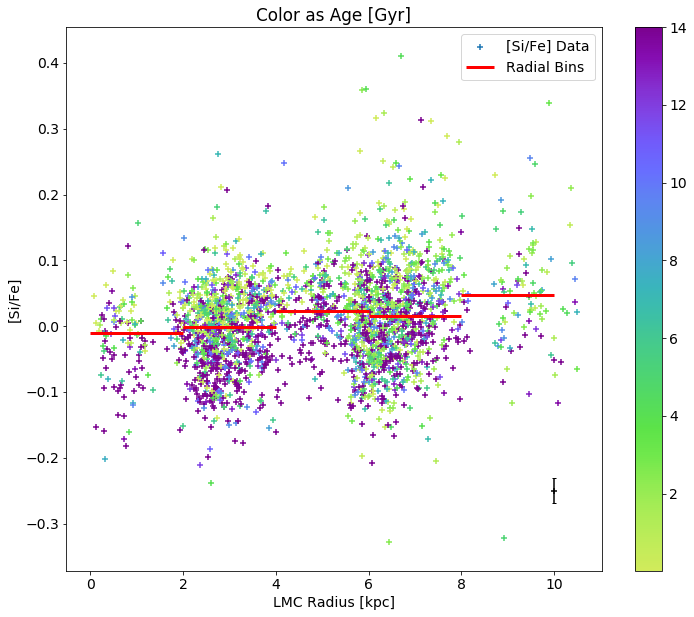

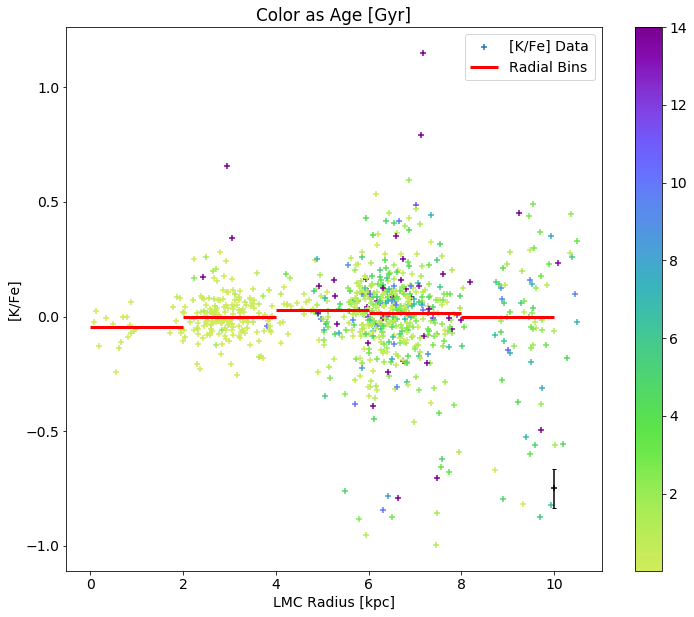

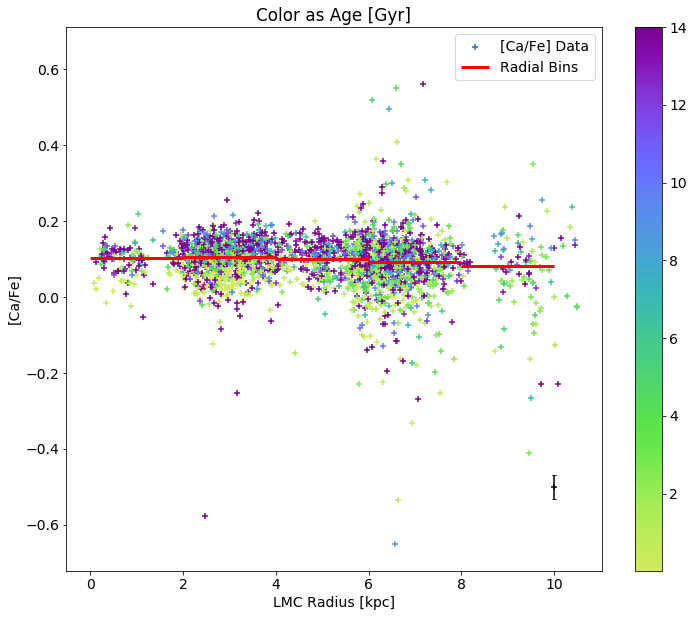

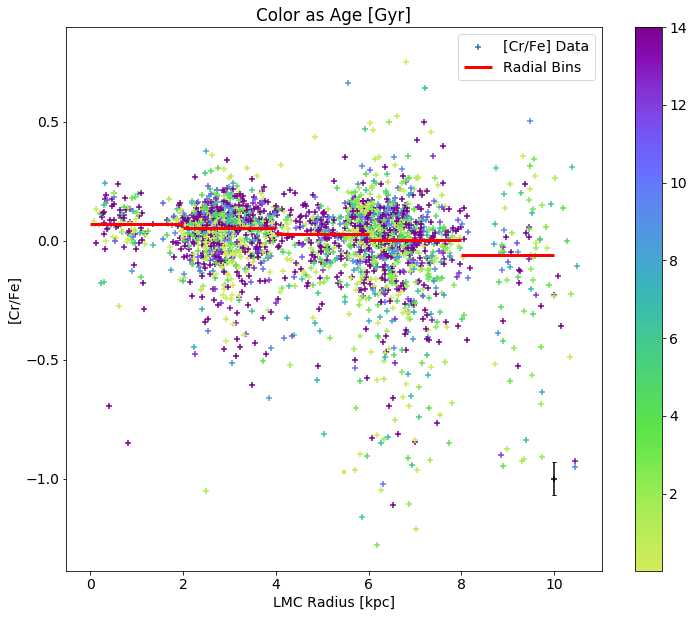

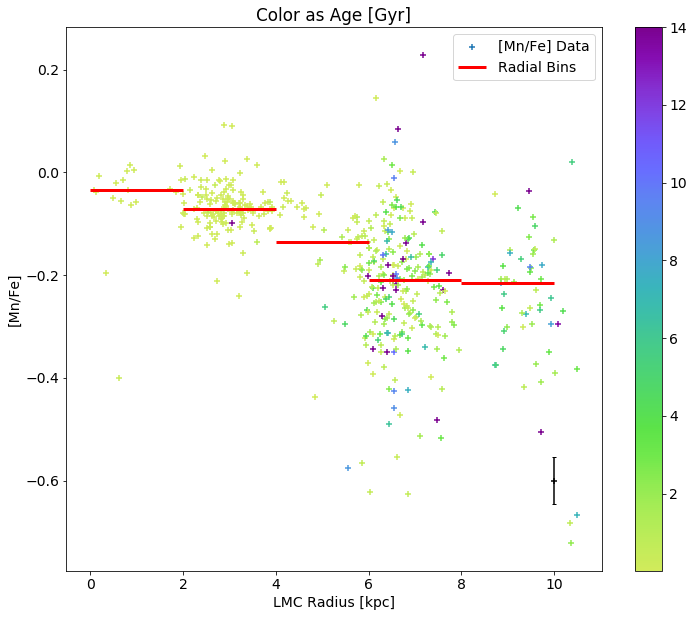

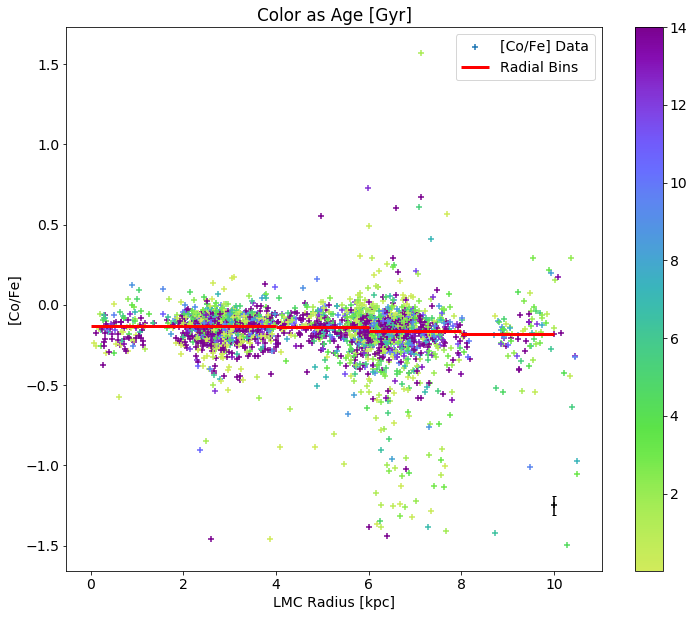

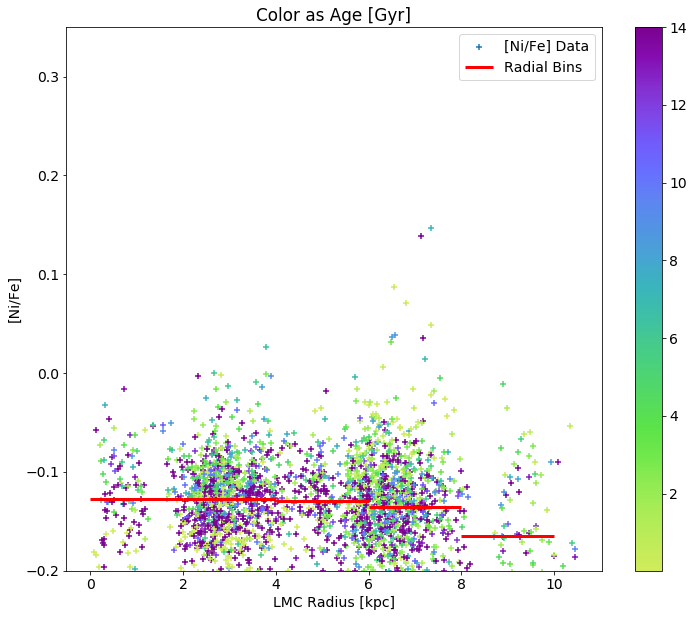

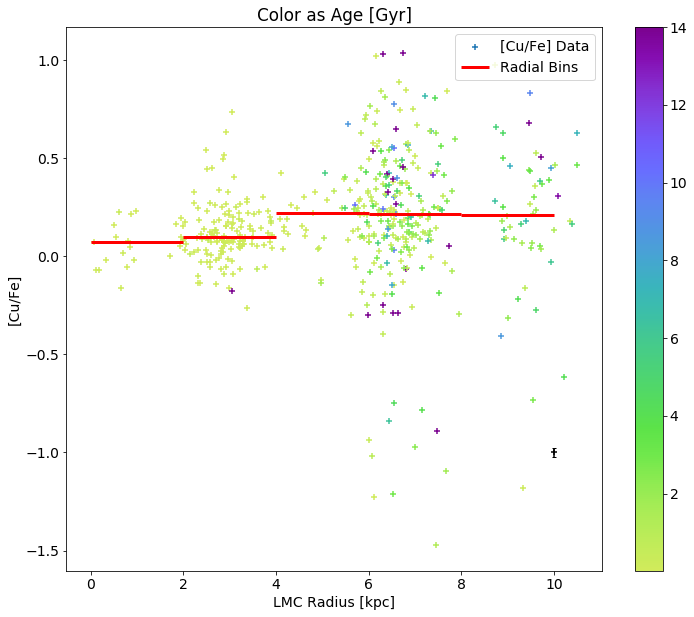

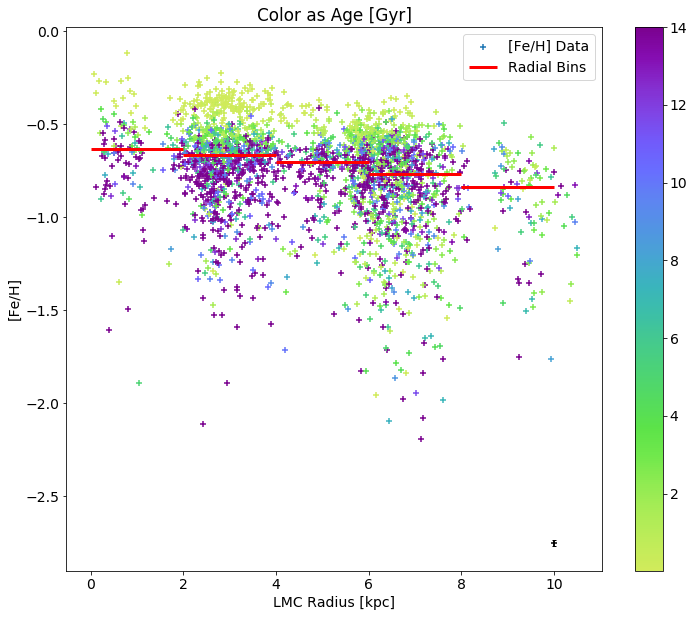

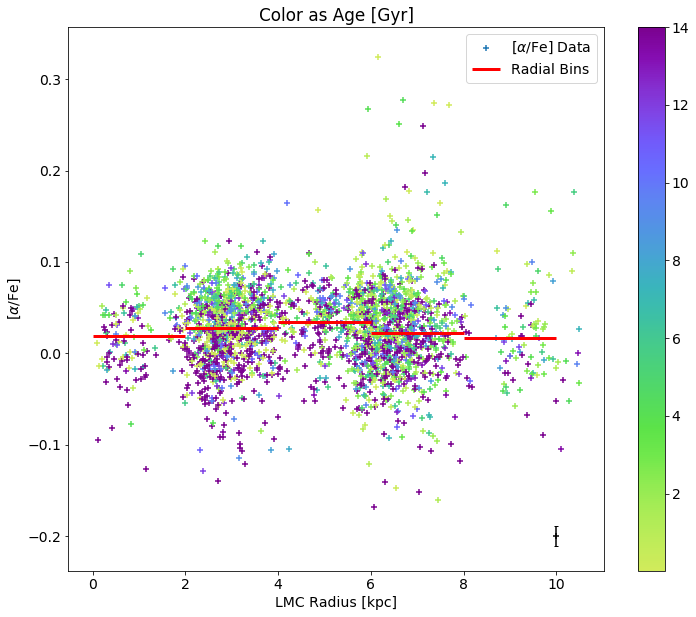

In [161]:
#########################
### Age and Abundance ###
#########################

import scipy.stats as st

plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'],clndr16['C_FE'],marker='+',c=10**parage/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[C/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['C_FE'],statistic='median',\
                                                      bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[C/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.0,marker='+',color='k')
plt.errorbar(10,-1.0,yerr=np.mean(clndr16['C_FE_ERR']),c='k',capsize=2)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_c.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'],clndr16['N_FE'],marker='+',c=10**parage/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[N/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['N_FE'],statistic='median',\
                                                      bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[N/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.2,marker='+',color='k')
plt.errorbar(10,-0.2,yerr=np.mean(clndr16['N_FE_ERR']),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_n.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'],clndr16['O_FE'],marker='+',c=10**parage/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[O/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['O_FE'],statistic='median',\
                                                      bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[O/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.2,marker='+',color='k')
plt.errorbar(10,-0.2,yerr=np.mean(clndr16['O_FE_ERR']),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_o.jpg',bbox_inches='tight')
plt.show()

clnna = np.where(clndr16['NA_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnna],clndr16['NA_FE'][clnna],marker='+',c=10**parage[clnna]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Na/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnna],clndr16['NA_FE'][clnna],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Na/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.5,marker='+',color='k')
plt.errorbar(10,-1.5,yerr=np.mean(clndr16['NA_FE_ERR'][clnna]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_na.jpg',bbox_inches='tight')
plt.show()

clnmg = np.where(clndr16['MG_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnmg],clndr16['MG_FE'][clnmg],marker='+',c=10**parage[clnmg]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Mg/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnmg],clndr16['MG_FE'][clnmg],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Mg/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.2,marker='+',color='k')
plt.errorbar(10,-0.2,yerr=np.mean(clndr16['MG_FE_ERR'][clnmg]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_mg.jpg',bbox_inches='tight')
plt.show()

clnal = np.where(clndr16['AL_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnal],clndr16['AL_FE'][clnal],marker='+',c=10**parage[clnal]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Al/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnal],clndr16['AL_FE'][clnal],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Al/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.0,marker='+',color='k')
plt.errorbar(10,-1.0,yerr=np.mean(clndr16['AL_FE_ERR'][clnal]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_al.jpg',bbox_inches='tight')
plt.show()

clnsi = np.where(clndr16['SI_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnsi],clndr16['SI_FE'][clnsi],marker='+',c=10**parage[clnsi]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Si/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnsi],clndr16['SI_FE'][clnsi],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Si/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.25,marker='+',color='k')
plt.errorbar(10,-0.25,yerr=np.mean(clndr16['SI_FE_ERR'][clnsi]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_si.jpg',bbox_inches='tight')
plt.show()

clnk = np.where(clndr16['K_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnk],clndr16['K_FE'][clnk],marker='+',c=10**parage[clnk]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[K/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnk],clndr16['K_FE'][clnk],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[K/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.75,marker='+',color='k')
plt.errorbar(10,-0.75,yerr=np.mean(clndr16['K_FE_ERR'][clnk]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_k.jpg',bbox_inches='tight')
plt.show()

clnca = np.where(clndr16['CA_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnca],clndr16['CA_FE'][clnca],marker='+',c=10**parage[clnca]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Ca/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnca],clndr16['CA_FE'][clnca],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Ca/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.5,marker='+',color='k')
plt.errorbar(10,-0.5,yerr=np.mean(clndr16['CA_FE_ERR'][clnca]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_ca.jpg',bbox_inches='tight')
plt.show()

clncr = np.where(clndr16['CR_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clncr],clndr16['CR_FE'][clncr],marker='+',c=10**parage[clncr]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Cr/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncr],clndr16['CR_FE'][clncr],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Cr/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.0,marker='+',color='k')
plt.errorbar(10,-1.0,yerr=np.mean(clndr16['CR_FE_ERR'][clncr]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_cr.jpg',bbox_inches='tight')
plt.show()

clnmn = np.where(clndr16['MN_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnmn],clndr16['MN_FE'][clnmn],marker='+',c=10**parage[clnmn]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Mn/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnmn],clndr16['MN_FE'][clnmn],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Mn/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.6,marker='+',color='k')
plt.errorbar(10,-0.6,yerr=np.mean(clndr16['MN_FE_ERR'][clnmn]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_mn.jpg',bbox_inches='tight')
plt.show()

clnco = np.where(clndr16['CO_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnco],clndr16['CO_FE'][clnco],marker='+',c=10**parage[clnco]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Co/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnco],clndr16['CO_FE'][clnco],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Co/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.25,marker='+',color='k')
plt.errorbar(10,-1.25,yerr=np.mean(clndr16['CO_FE_ERR'][clnco]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_co.jpg',bbox_inches='tight')
plt.show()

plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'],clndr16['NI_FE'],marker='+',c=10**parage/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Ni/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'],clndr16['NI_FE'],statistic='median',\
                                                      bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Ni/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.35,marker='+',color='k')
plt.errorbar(10,-0.35,yerr=np.mean(clndr16['NI_FE_ERR']),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_ni.jpg',bbox_inches='tight')
plt.show()

clncu = np.where(clndr16['CU_FE']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clncu],clndr16['CU_FE'][clncu],marker='+',c=10**parage[clncu]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Cu/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clncu],clndr16['CU_FE'][clncu],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Cu/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-1.0,marker='+',color='k')
plt.errorbar(10,-1.0,yerr=np.mean(clndr16['C_FE_ERR'][clncu]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_cu.jpg',bbox_inches='tight')
plt.show()

clnfe = np.where(clndr16['FE_H']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clnfe],clndr16['FE_H'][clnfe],marker='+',c=10**parage[clnfe]/10**9,\
            cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,label='[Fe/H] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clnfe],clndr16['FE_H'][clnfe],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[Fe/H]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-2.75,marker='+',color='k')
plt.errorbar(10,-2.75,yerr=np.mean(clndr16['FE_H_ERR'][clncu]),c='k',capsize=2)
# plt.ylim(-0.5,1.0)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_fe.jpg',bbox_inches='tight')
plt.show()

clna = np.where(clndr16['ALPHA_M']>=-10)
plt.figure(figsize=[12,10])
plt.scatter(clndr16['LMCRAD'][clna],(clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[clna],marker='+',\
            c=10**parage[clna]/10**9,cmap=pal.mycarta.CubeYF_20_r.mpl_colormap,alpha=1.0,\
            label=r'[$\alpha$/Fe] Data',vmax=14)
plt.colorbar()
bin_means, bin_edges, binnumber = st.binned_statistic(clndr16['LMCRAD'][clna],\
                                                      (clndr16['ALPHA_M']+clndr16['M_H']-clndr16['FE_H'])[clna],\
                                                      statistic='median',bins=[0,2,4,6,8,10])
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=3.0,label='Radial Bins')
plt.ylabel(r'[$\alpha$/Fe]')
plt.xlabel(r'LMC Radius [kpc]')
plt.scatter(10,-0.2,marker='+',color='k')
plt.errorbar(10,-0.2,yerr=np.mean((clndr16['ALPHA_M_ERR']+clndr16['M_H_ERR']-clndr16['FE_H_ERR'])[clna]),\
             c='k',capsize=2)
# plt.ylim(-0.5,1.0)
# plt.ylim(-0.2,0.35)
plt.title(r'Color as Age [Gyr]')
plt.legend(loc='upper right')
plt.savefig('parsec_age_alpha.jpg',bbox_inches='tight')
plt.show()